# What Leaderboards Reveal About LLM Evolution

*   Amit Avitan

# Import Libraries

In [33]:
import os
import re
import time
from datetime import datetime
import requests

from dateutil.relativedelta import relativedelta
from huggingface_hub import hf_hub_download, login
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import seaborn as sns
import torch
from transformers import pipeline
import math
from matplotlib.lines import Line2D
from matplotlib import ticker as mticker
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter


# Load Data

## Git LeaderBoard

In [34]:
!git clone https://github.com/Weyaxi/scrape-open-llm-leaderboard

fatal: destination path 'scrape-open-llm-leaderboard' already exists and is not an empty directory.


In [35]:
!cd scrape-open-llm-leaderboard

In [36]:
!pip3 install -r scrape-open-llm-leaderboard/requirements.txt

In [37]:
!python3 scrape-open-llm-leaderboard/main.py -csv

Data exported to CSV


In [38]:
# Load the data
df = pd.read_csv("open-llm-leaderboard.csv")
df['Submission Date'] = pd.to_datetime(df['Submission Date'], errors='coerce')

# Select and clean key columns
df_clean = df[['fullname', 'Submission Date', 'Average ⬆️', '#Params (B)', 'Architecture']].copy()
df_clean.rename(columns={
    'Average ⬆️': 'average_score',
    '#Params (B)': 'params_b',
    'Submission Date': 'submission_date'
}, inplace=True)
df_clean.dropna(subset=['average_score', 'params_b', 'submission_date'], inplace=True)

# Add time features
df_clean['year'] = df_clean['submission_date'].dt.year
df_clean['month'] = df_clean['submission_date'].dt.to_period("M")

# Add efficiency metric (score per log-scale params)
df_clean['efficiency'] = df_clean['average_score'] / np.log10(df_clean['params_b'] * 1e9)

# Sort for top efficiency
top_efficient = df_clean.sort_values('efficiency', ascending=False).head(20)

# Set Seaborn style
sns.set(style='whitegrid', font_scale=1.2)
plt.rcParams['figure.dpi'] = 120

df_clean

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,fullname,submission_date,average_score,params_b,Architecture,year,month,efficiency
0,MaziyarPanahi/calme-3.2-instruct-78b,2024-11-28,52.081384,77.965,Qwen2ForCausalLM,2024,2024-11,4.781662
1,MaziyarPanahi/calme-3.1-instruct-78b,2024-11-27,51.287490,77.965,Qwen2ForCausalLM,2024,2024-11,4.708774
2,dfurman/CalmeRys-78B-Orpo-v0.1,2024-09-24,51.231323,77.965,Qwen2ForCausalLM,2024,2024-09,4.703617
3,MaziyarPanahi/calme-2.4-rys-78b,2024-09-03,50.765047,77.965,Qwen2ForCausalLM,2024,2024-09,4.660807
4,huihui-ai/Qwen2.5-72B-Instruct-abliterated,2024-12-07,48.106471,72.706,Qwen2ForCausalLM,2024,2024-12,4.429053
...,...,...,...,...,...,...,...,...
4571,INSAIT-Institute/BgGPT-Gemma-2-27B-IT-v1.0,2024-12-15,1.678063,27.227,Gemma2ForCausalLM,2024,2024-12,0.160811
4572,NucleusAI/nucleus-22B-token-500B,2024-06-26,1.633416,21.828,LlamaForCausalLM,2024,2024-06,0.157986
4573,pankajmathur/orca_mini_v6_8b,2024-06-26,1.476339,8.030,LlamaForCausalLM,2024,2024-06,0.149054
4574,PrimeIntellect/INTELLECT-1-Instruct,2024-11-29,1.405911,10.211,LlamaForCausalLM,2024,2024-11,0.140464


In [39]:
df.columns

Index(['eval_name', 'Precision', 'Type', 'T', 'Weight type', 'Architecture',
       'Model', 'fullname', 'Model sha', 'Average ⬆️', 'Hub License', 'Hub ❤️',
       '#Params (B)', 'Available on the hub', 'MoE', 'Flagged',
       'Chat Template', 'CO₂ cost (kg)', 'IFEval Raw', 'IFEval', 'BBH Raw',
       'BBH', 'MATH Lvl 5 Raw', 'MATH Lvl 5', 'GPQA Raw', 'GPQA', 'MUSR Raw',
       'MUSR', 'MMLU-PRO Raw', 'MMLU-PRO', 'Merged', 'Official Providers',
       'Upload To Hub Date', 'Submission Date', 'Generation', 'Base Model'],
      dtype='object')

In [40]:
print(df.columns.tolist())


['eval_name', 'Precision', 'Type', 'T', 'Weight type', 'Architecture', 'Model', 'fullname', 'Model sha', 'Average ⬆️', 'Hub License', 'Hub ❤️', '#Params (B)', 'Available on the hub', 'MoE', 'Flagged', 'Chat Template', 'CO₂ cost (kg)', 'IFEval Raw', 'IFEval', 'BBH Raw', 'BBH', 'MATH Lvl 5 Raw', 'MATH Lvl 5', 'GPQA Raw', 'GPQA', 'MUSR Raw', 'MUSR', 'MMLU-PRO Raw', 'MMLU-PRO', 'Merged', 'Official Providers', 'Upload To Hub Date', 'Submission Date', 'Generation', 'Base Model']


## API artificialanalysis

In [41]:
api_key = 'aa_MjFNDxdcUhFUoMkyeXwYwRDzVkRqmWca'

In [42]:
# Replace with your actual API key
API_KEY = api_key

# API endpoint
url = "https://artificialanalysis.ai/api/v2/data/llms/models"

# Headers
headers = {
    "x-api-key": API_KEY
}

# Send GET request
response = requests.get(url, headers=headers)

if response.status_code == 200:
    json_data = response.json()
    models = json_data.get("data", [])

    # Flatten nested dicts: model_creator, evaluations, pricing
    df = pd.json_normalize(
        models,
        sep="_"  # use underscore for nested keys
    )

    # Show DataFrame info
    print(f"Retrieved {len(df)} models")
    print(df.head())

    # Example: Save to CSV
    df.to_csv("llm_models.csv", index=False)
    print("Data saved to llm_models.csv")
else:
    print(f"Error {response.status_code}: {response.text}")


Retrieved 251 models
                                     id          name          slug  \
0  b5c1c91a-7474-4409-9a9c-9c2ac45d9eb6   GPT-4o mini   gpt-4o-mini   
1  72c358fd-7d45-4d68-89aa-699743710924  GPT-4.1 nano  gpt-4-1-nano   
2  4c111fbc-d13a-42b4-858c-1dc17fe3c1d1        Grok-1        grok-1   
3  f0083258-8646-45b8-8082-7aaf6c2ea82a  gpt-oss-120B  gpt-oss-120b   
4  36f73aaf-d38a-4b56-a2b3-d04d17186910   gpt-oss-20B   gpt-oss-20b   

  release_date  median_output_tokens_per_second  \
0   2024-07-18                           57.688   
1   2025-04-14                           84.201   
2   2024-03-17                              NaN   
3   2025-08-05                          232.641   
4   2025-08-05                          259.635   

   median_time_to_first_token_seconds  median_time_to_first_answer_token  \
0                               0.511                              0.511   
1                               0.402                              0.402   
2                

In [43]:
# Load data
llm_models = pd.read_csv("llm_models.csv")
open_llm_leaderboard = pd.read_csv("open-llm-leaderboard.csv")

# Preprocess dates
llm_models['release_date'] = pd.to_datetime(llm_models['release_date'], errors='coerce')
open_llm_leaderboard['Submission Date'] = pd.to_datetime(open_llm_leaderboard['Submission Date'], errors='coerce')

# Set global style
sns.set(style="whitegrid", palette="Set2")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14

# Color palette
colors = sns.color_palette("Set2")

# Results

## 1

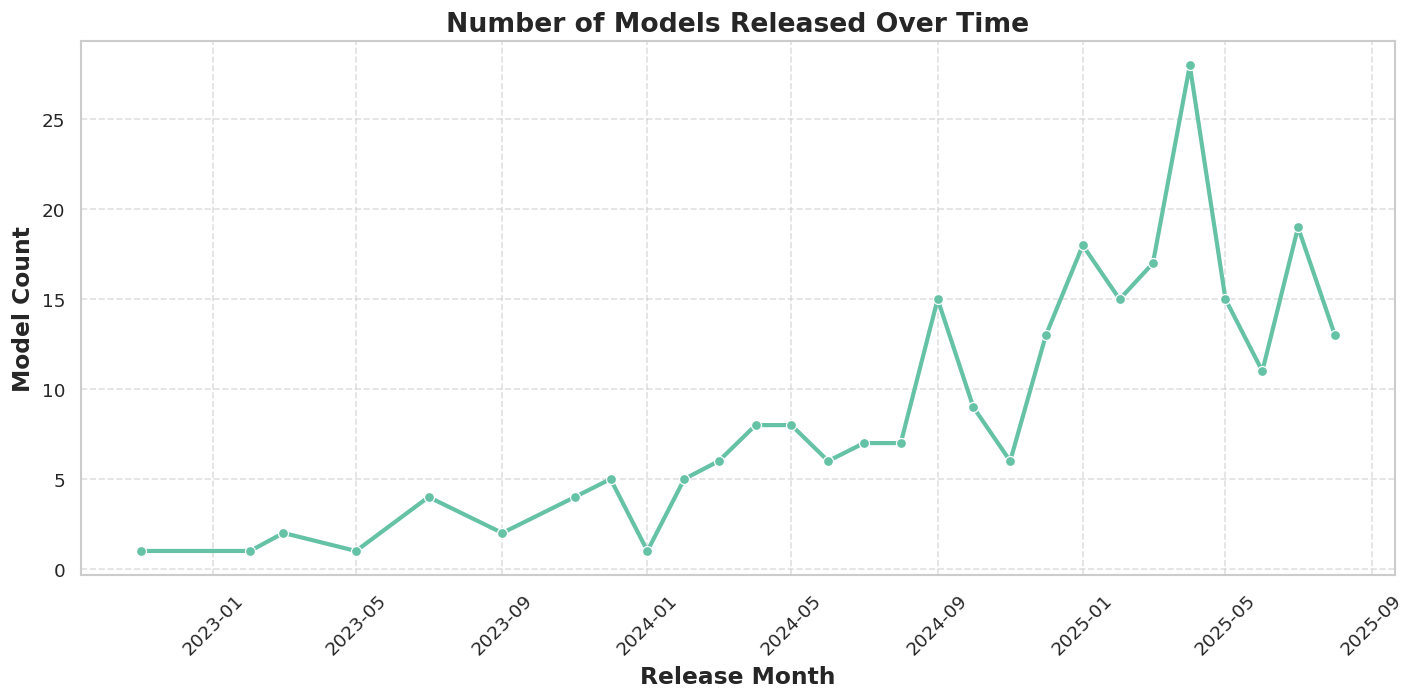

In [12]:
# 1. Timeline of Model Releases
release_timeline = llm_models.dropna(subset=['release_date']).copy()
release_timeline['release_month'] = release_timeline['release_date'].dt.to_period("M").dt.to_timestamp()
release_counts = release_timeline.groupby('release_month')['name'].count().reset_index(name='model_count')

sns.lineplot(
    data=release_counts,
    x='release_month',
    y='model_count',
    marker='o',
    linewidth=2.5,
    color=colors[0]
)

# Bold title and labels
plt.title("Number of Models Released Over Time", fontweight="bold")
plt.xlabel("Release Month", fontweight="bold")
plt.ylabel("Model Count", fontweight="bold")

# Style tweaks
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## 2

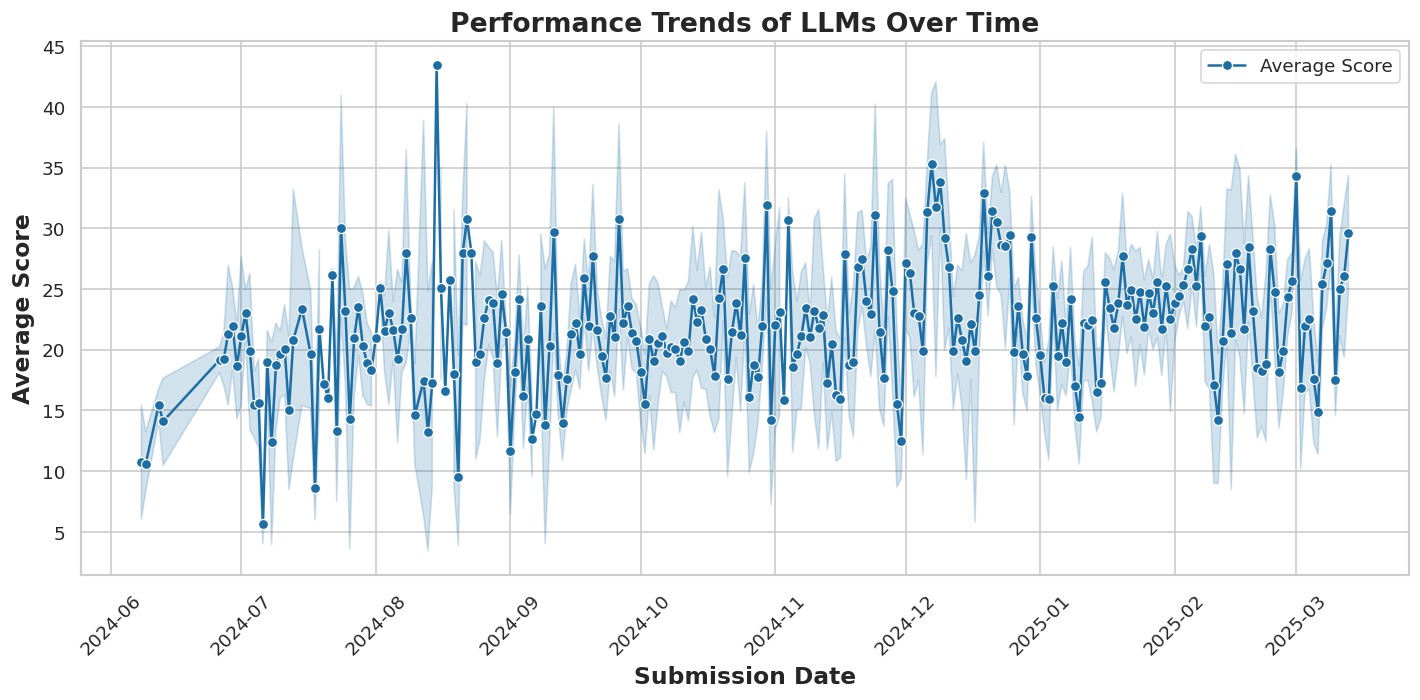

In [13]:
sns.lineplot(data=df_clean.sort_values('submission_date'),
             x='submission_date', y='average_score',
             label='Average Score', marker='o', color="#1C6EA4")
plt.title("Performance Trends of LLMs Over Time", fontweight="bold")
plt.xlabel("Submission Date", fontweight="bold")
plt.ylabel("Average Score", fontweight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

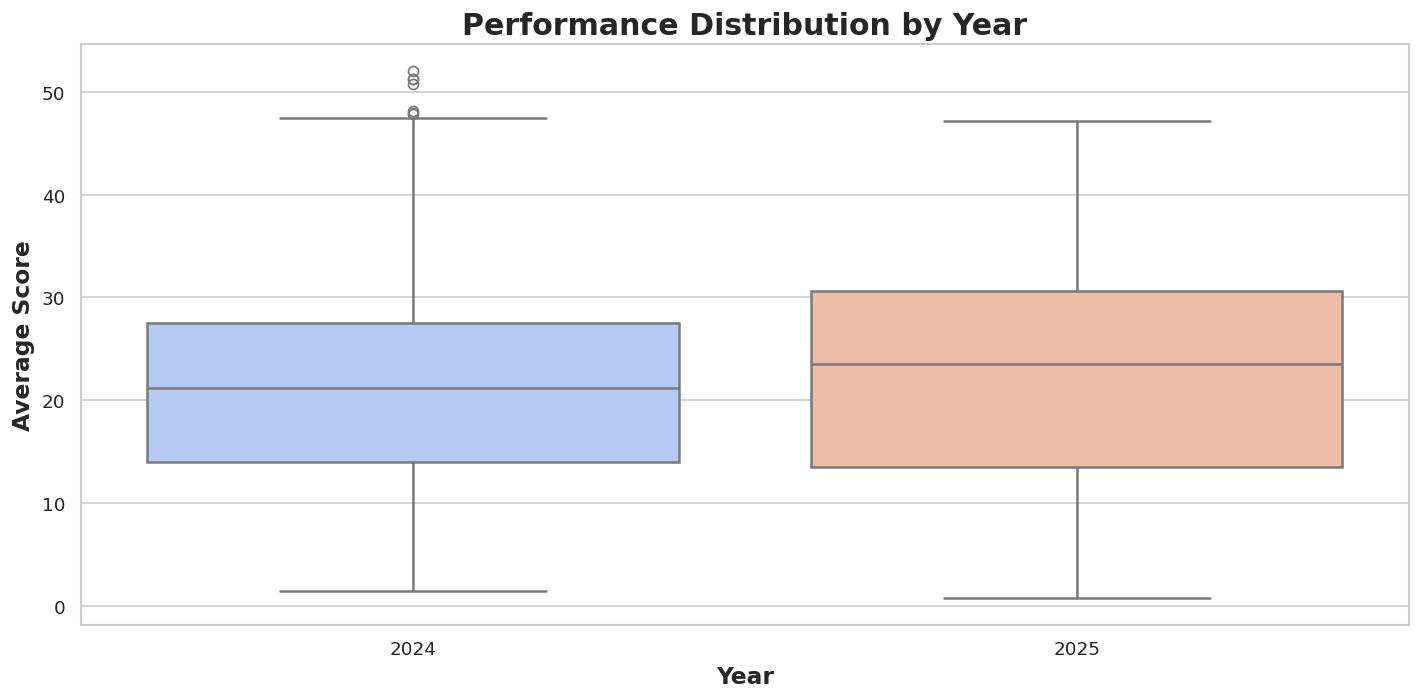

In [14]:

# Boxplot with custom style
sns.boxplot(
    data=df_clean,
    x='year',
    y='average_score',
    hue='year',
    palette=sns.color_palette("coolwarm", n_colors=df_clean['year'].nunique()),
    legend=False,
    linewidth=1.5,  # thicker edges
    saturation=0.75
)


# Style title and labels
plt.title("Performance Distribution by Year", fontsize=18, fontweight="bold")
plt.xlabel("Year", fontweight="bold")
plt.ylabel("Average Score", fontweight="bold")

plt.tight_layout()
plt.show()

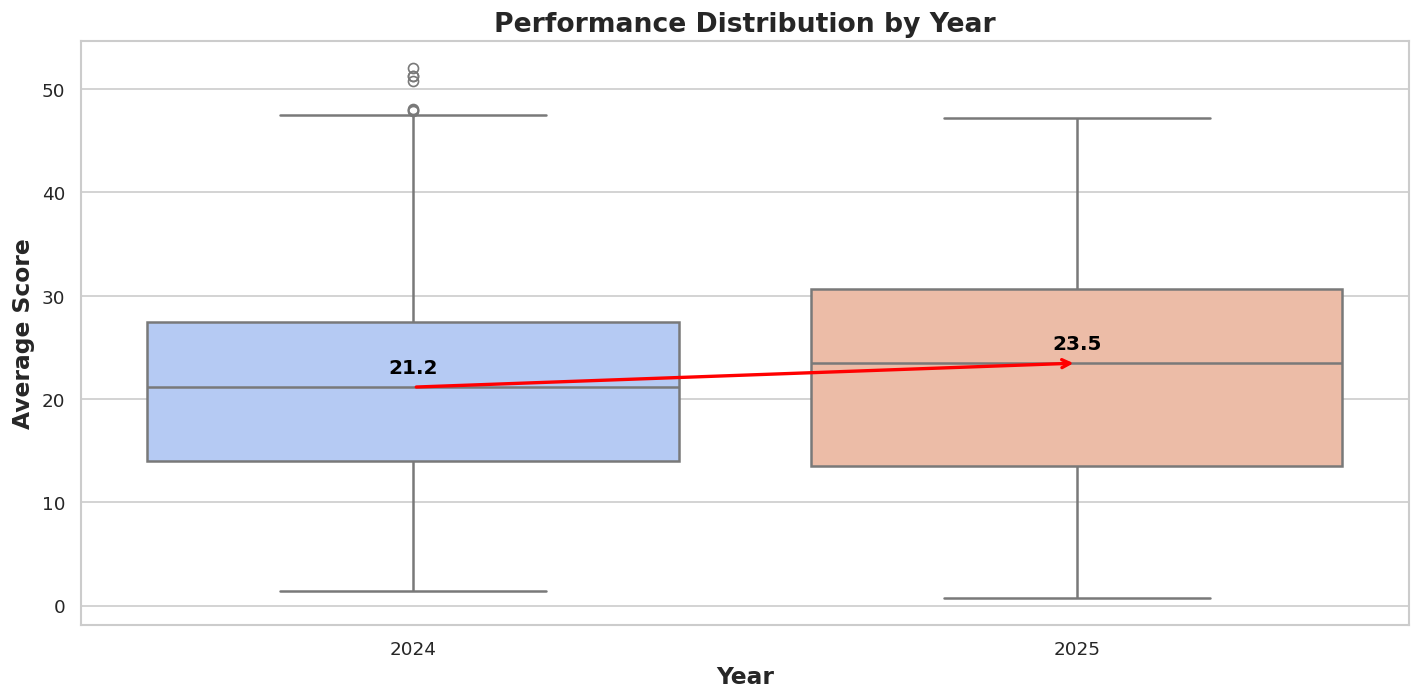

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


ax = sns.boxplot(
    data=df_clean,
    x='year',
    y='average_score',
    hue='year',
    palette=sns.color_palette("coolwarm", n_colors=df_clean['year'].nunique()),
    legend=False,
    linewidth=1.5,
    saturation=0.75
)

# Calculate medians for annotation
medians = df_clean.groupby("year")["average_score"].median()
median_2024 = medians.loc[2024]
median_2025 = medians.loc[2025]

# Add median value text above boxes
ax.text(0, median_2024 + 1, f"{median_2024:.1f}",
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
ax.text(1, median_2025 + 1, f"{median_2025:.1f}",
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Add arrow to show increase
ax.annotate(
    '',
    xy=(1, median_2025), xycoords='data',
    xytext=(0, median_2024), textcoords='data',
    arrowprops=dict(arrowstyle="->", lw=2, color="red")
)

# Title and labels
plt.title("Performance Distribution by Year", fontweight="bold")
plt.xlabel("Year",  fontweight="bold")
plt.ylabel("Average Score", fontweight="bold")

plt.tight_layout()
plt.show()


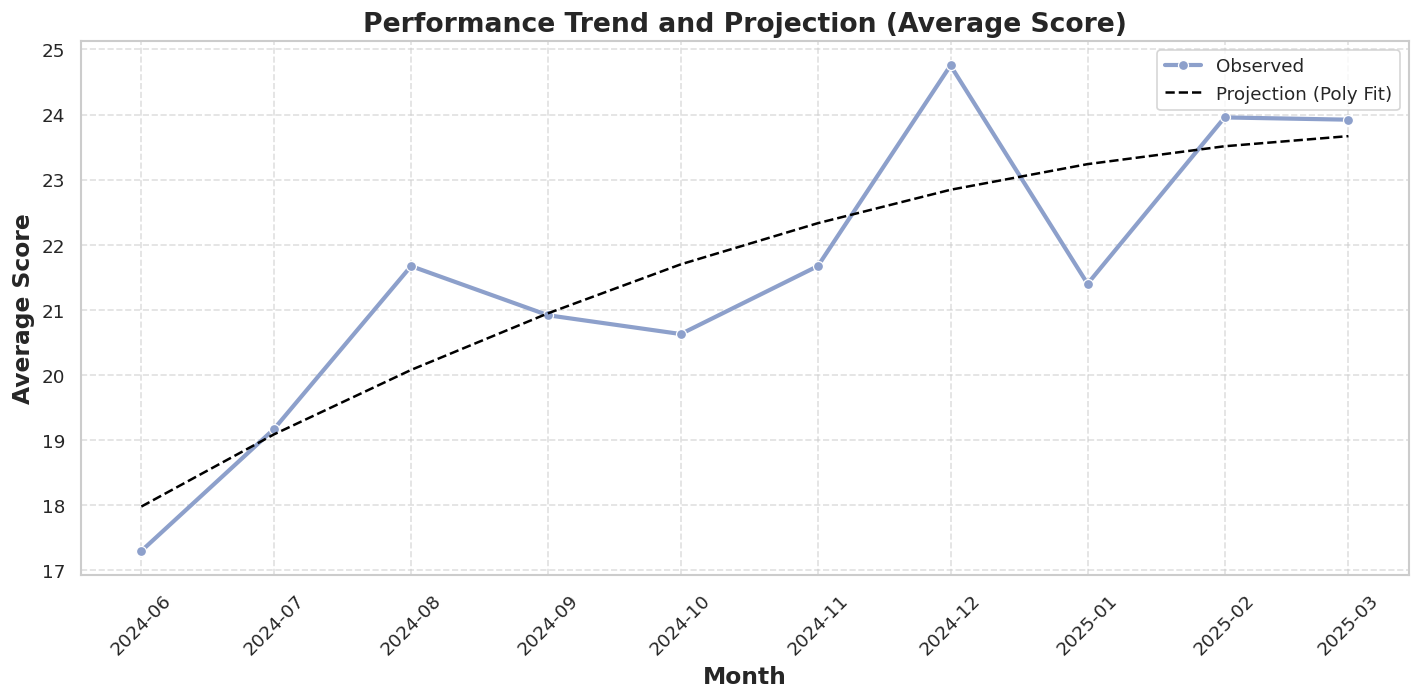

In [16]:
score_trend = open_llm_leaderboard[['Submission Date', 'Average ⬆️']].dropna()
score_trend['month'] = score_trend['Submission Date'].dt.to_period('M').dt.to_timestamp()
monthly_avg = score_trend.groupby('month')['Average ⬆️'].mean().reset_index()
z = np.polyfit(monthly_avg.index, monthly_avg['Average ⬆️'], 2)
p = np.poly1d(z)
plt.figure()
sns.lineplot(data=monthly_avg, x='month', y='Average ⬆️', label='Observed', marker='o', color=colors[2], linewidth=2.5)
sns.lineplot(x=monthly_avg['month'], y=p(monthly_avg.index), label='Projection (Poly Fit)', linestyle='--', color='black')
plt.title("Performance Trend and Projection (Average Score)", fontweight="bold")
plt.xlabel("Month", fontweight="bold")
plt.ylabel("Average Score", fontweight="bold")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 3

Slopes (higher = faster improvement):
MATH Lvl 5  : 0.0557
IFEval      : 0.0278
Average ⬆️  : 0.0207
MMLU-PRO    : 0.0168
BBH         : 0.0121
GPQA        : 0.0090
MUSR        : 0.0030


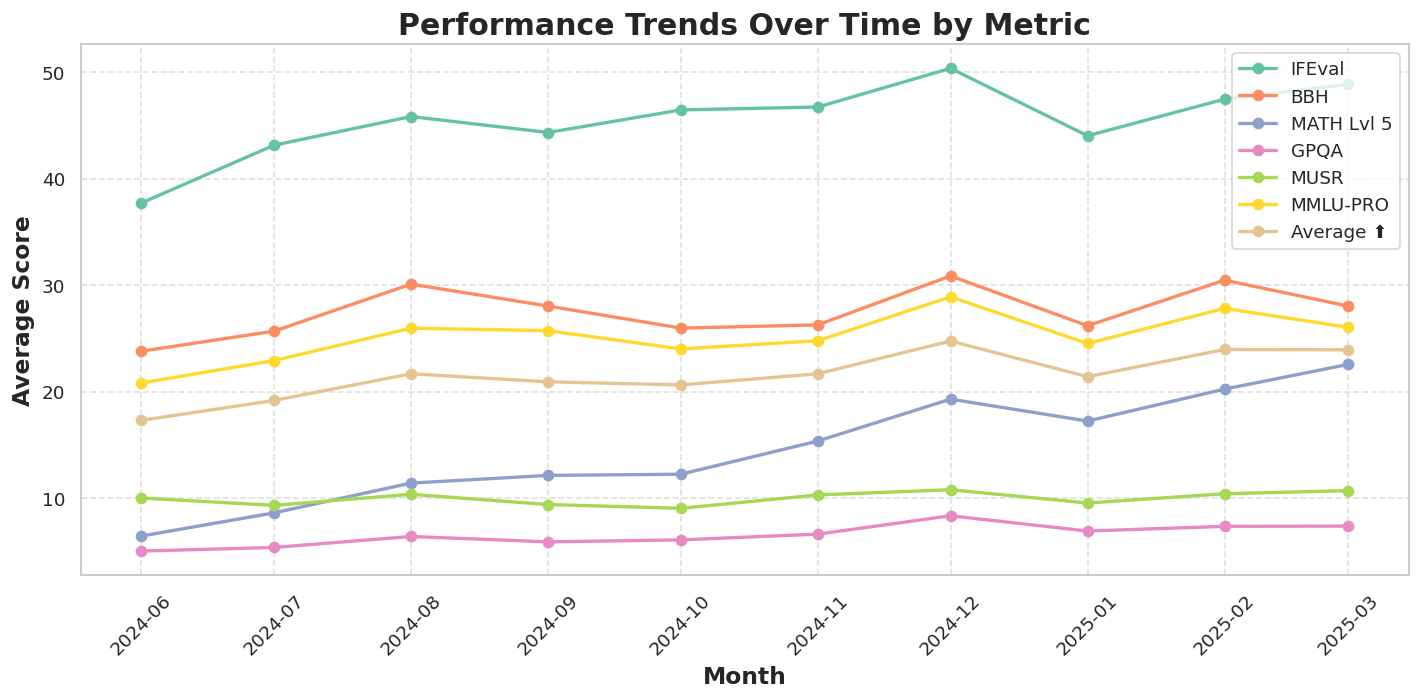

In [17]:


df = open_llm_leaderboard.copy()
df['Submission Date'] = pd.to_datetime(df['Submission Date'], errors='coerce')

# Keep only valid dates and make an explicit copy (prevents SettingWithCopyWarning)
df_filtered = df.loc[df['Submission Date'].notna()].copy()

metrics_to_analyze = ["IFEval", "BBH", "MATH Lvl 5", "GPQA", "MUSR", "MMLU-PRO", "Average ⬆️"]

# Ensure metrics are numeric (some may be objects/strings)
for m in metrics_to_analyze:
    df_filtered[m] = pd.to_numeric(df_filtered[m], errors='coerce')

# Month column (no warning because we're working on a copy)
df_filtered['Month'] = df_filtered['Submission Date'].dt.to_period('M').dt.to_timestamp()

trend_data = (df_filtered
              .groupby('Month')[metrics_to_analyze]
              .mean()
              .reset_index())

# Use calendar time spacing for slope (days since first month)
x = (trend_data['Month'] - trend_data['Month'].min()).dt.days.values

slopes = {}
for metric in metrics_to_analyze:
    y = trend_data[metric].values
    mask = ~np.isnan(y)
    if mask.sum() >= 2:
        slopes[metric] = np.polyfit(x[mask], y[mask], 1)[0]
    else:
        slopes[metric] = np.nan

sorted_slopes = dict(sorted(slopes.items(), key=lambda kv: (np.nan_to_num(kv[1], nan=-np.inf)), reverse=True))
print("Slopes (higher = faster improvement):")
for k, v in sorted_slopes.items():
    print(f"{k:12s}: {v:.4f}")

# Plot
plt.figure(figsize=(12, 6))
for metric in metrics_to_analyze:
    plt.plot(trend_data['Month'], trend_data[metric], marker='o', linewidth=2, label=metric)

plt.title("Performance Trends Over Time by Metric", fontsize=18, fontweight="bold")
plt.xlabel("Month", fontweight="bold")
plt.ylabel("Average Score", fontweight="bold")
plt.legend(frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Highest slope: MATH Lvl 5 (0.0557)


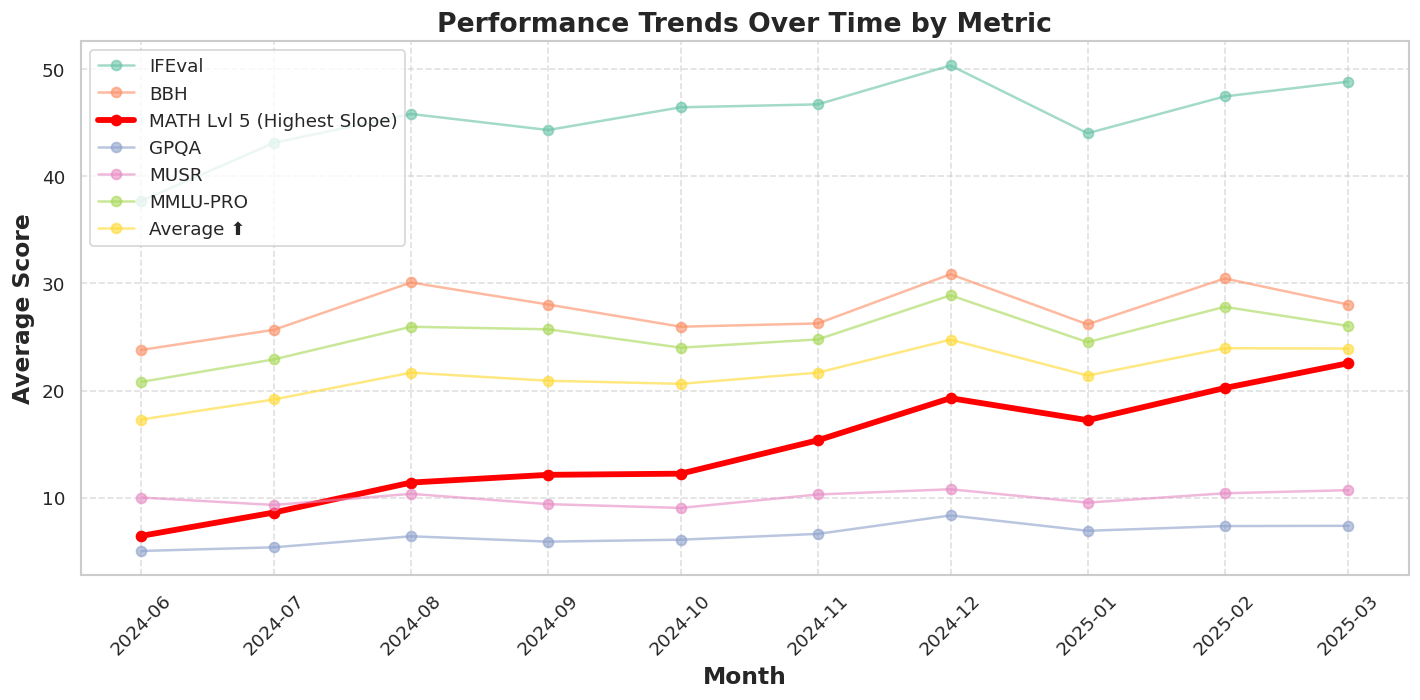

In [18]:


df = open_llm_leaderboard.copy()
df['Submission Date'] = pd.to_datetime(df['Submission Date'], errors='coerce')

# Keep only valid dates and make an explicit copy
df_filtered = df.loc[df['Submission Date'].notna()].copy()

metrics_to_analyze = ["IFEval", "BBH", "MATH Lvl 5", "GPQA", "MUSR", "MMLU-PRO", "Average ⬆️"]

# Ensure metrics are numeric
for m in metrics_to_analyze:
    df_filtered[m] = pd.to_numeric(df_filtered[m], errors='coerce')

# Add month column
df_filtered['Month'] = df_filtered['Submission Date'].dt.to_period('M').dt.to_timestamp()

# Average per month
trend_data = df_filtered.groupby('Month')[metrics_to_analyze].mean().reset_index()

# Calculate slopes using real time spacing
x = (trend_data['Month'] - trend_data['Month'].min()).dt.days.values
slopes = {}
for metric in metrics_to_analyze:
    y = trend_data[metric].values
    mask = ~np.isnan(y)
    if mask.sum() >= 2:
        slopes[metric] = np.polyfit(x[mask], y[mask], 1)[0]
    else:
        slopes[metric] = np.nan

# Find metric with highest slope
top_metric = max(slopes, key=lambda k: slopes[k])
print(f"Highest slope: {top_metric} ({slopes[top_metric]:.4f})")

# Plot
plt.figure(figsize=(12, 6))
for metric in metrics_to_analyze:
    if metric == top_metric:
        plt.plot(trend_data['Month'], trend_data[metric], marker='o',
                 linewidth=3.5, label=f"{metric} (Highest Slope)",
                 color='red')
    else:
        plt.plot(trend_data['Month'], trend_data[metric], marker='o',
                 linewidth=1.5, alpha=0.6, label=metric)

# Bold title and labels
plt.title("Performance Trends Over Time by Metric", fontweight="bold")
plt.xlabel("Month", fontweight="bold")
plt.ylabel("Average Score", fontweight="bold")
plt.legend(frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


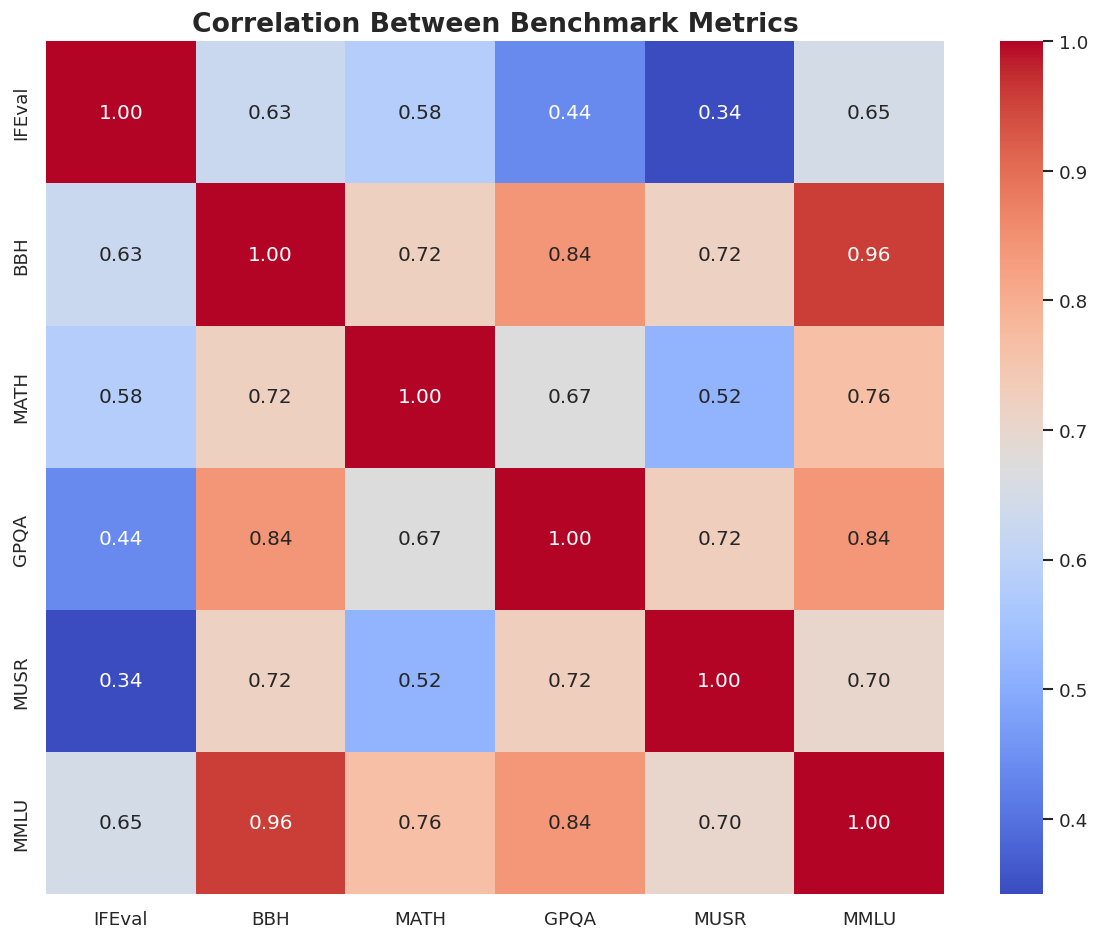

In [19]:
# Advanced Graph 1: Correlation heatmap between major benchmark metrics
df = open_llm_leaderboard.copy()
df_benchmarks = df[[
    'IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO', 'Average ⬆️'
]].dropna()

df_benchmarks = df[[
    'IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO'
]].dropna()

# Rename for easier display
# df_benchmarks.columns = ['IFEval', 'BBH', 'MATH', 'GPQA', 'MUSR', 'MMLU', 'Average Score']
df_benchmarks.columns = ['IFEval', 'BBH', 'MATH', 'GPQA', 'MUSR', 'MMLU']


# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_benchmarks.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Benchmark Metrics", fontweight="bold")
plt.tight_layout()
plt.show()

## 4

In [20]:
df = llm_models.copy()
recent_cut = df['release_date'].max() - pd.Timedelta(days=120)
focus = df[df['release_date'] >= recent_cut].copy()

# Map for renaming metrics
metric_rename = {
    'evaluations_artificial_analysis_intelligence_index': 'General Intelligence',
    'evaluations_artificial_analysis_coding_index': 'Coding',
    'evaluations_artificial_analysis_math_index': 'Math',
    'evaluations_mmlu_pro': 'MMLU-PRO',
    'evaluations_gpqa': 'GPQA'
}

# Filter only existing columns
metrics = [m for m in metric_rename if m in df.columns]

def top_share(metric, top_k=20):
    sub = focus[['name','model_creator_name','release_date', metric]].dropna(subset=[metric])
    top = sub.sort_values(metric, ascending=False).head(top_k)
    share = (top['model_creator_name']
             .value_counts(normalize=True)
             .rename('share')
             .to_frame()
             .assign(metric=metric_rename[metric]))  # Use renamed metric here
    return share

# Compute shares
pieces = []
for m in metrics:
    pieces.append(top_share(m, top_k=20))

shares = pd.concat(pieces)

# Reset index for nicer display (optional)
shares = shares.reset_index().rename(columns={'index': 'model_creator_name'})

shares

,model_creator_name,share,metric
0,OpenAI,0.35,General Intelligence
1,Google,0.15,General Intelligence
2,Anthropic,0.15,General Intelligence
3,Alibaba,0.10,General Intelligence
4,DeepSeek,0.10,General Intelligence
5,xAI,0.05,General Intelligence
6,Z AI,0.05,General Intelligence
7,MiniMax,0.05,General Intelligence
8,OpenAI,0.25,Coding
9,Google,0.15,Coding


In [21]:
metric_rename = {
    'evaluations_artificial_analysis_intelligence_index': 'General Intelligence',
    'evaluations_artificial_analysis_coding_index': 'Coding',
    'evaluations_artificial_analysis_math_index': 'Math',
    'evaluations_mmlu_pro': 'MMLU-PRO',
    'evaluations_gpqa': 'GPQA'
}

df['release_month'] = pd.to_datetime(df['release_date']).dt.to_period('M').dt.to_timestamp()
winners = []

metrics = [m for m in metric_rename if m in df.columns]

for m in metrics:
    monthly_creator = (df.dropna(subset=[m])
                         .groupby(['release_month','model_creator_name'])[m]
                         .mean()
                         .reset_index())
    top_per_month = (monthly_creator
                     .sort_values([ 'release_month', m ], ascending=[True, False])
                     .groupby('release_month')
                     .head(1)
                     .assign(metric=metric_rename[m]))
    winners.append(top_per_month)

winners = pd.concat(winners)
win_rate = (winners.groupby(['metric','model_creator_name'])
            .size().rename('months_at_#1')
            .reset_index()
            .sort_values(['metric','months_at_#1'], ascending=[True, False]))

win_rate


,metric,model_creator_name,months_at_#1
7,Coding,OpenAI,7
1,Coding,Anthropic,4
5,Coding,Mistral,3
8,Coding,xAI,3
0,Coding,Alibaba,2
2,Coding,DeepSeek,1
3,Coding,Google,1
4,Coding,MiniMax,1
6,Coding,NVIDIA,1
15,GPQA,OpenAI,9


/tmp/ipython-input-357967641.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


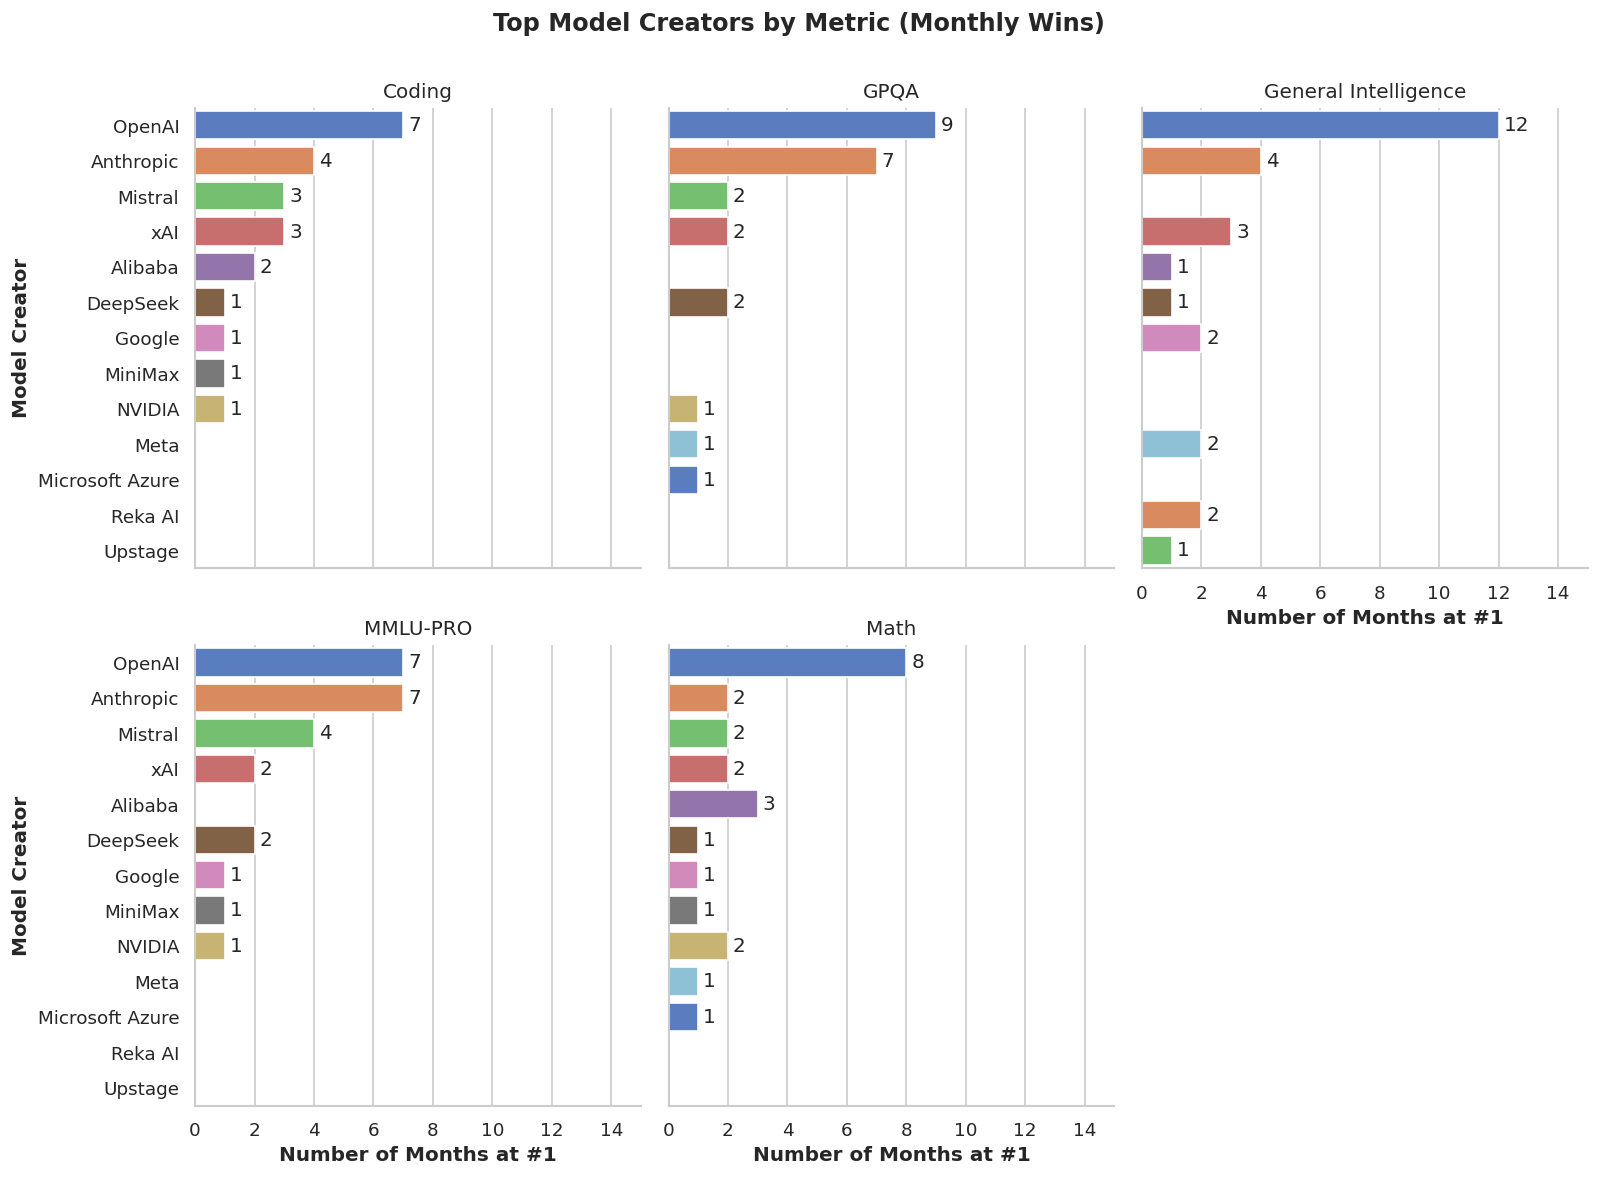

In [22]:
# Setup
sns.set(style="whitegrid")

# Ensure column types
win_rate_sorted = win_rate.copy()
win_rate_sorted['model_creator_name'] = win_rate_sorted['model_creator_name'].astype(str)

# Define max x-axis
MAX_X = 15

# Plot
g = sns.catplot(
    data=win_rate_sorted,
    x='months_at_#1',
    y='model_creator_name',
    col='metric',
    kind='bar',
    height=5,
    aspect=0.9,
    col_wrap=3,
    palette='muted',
    sharex=True
)

# Customize axes and add labels
for ax in g.axes.flat:
    ax.set_xlim(0, MAX_X)
    ax.set_xlabel("Number of Months at #1", fontweight="bold")
    ax.set_ylabel("Model Creator", fontweight="bold")

    # Add value labels to bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Final layout and title
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Top Model Creators by Metric (Monthly Wins)", fontweight="bold")

plt.show()


## 5

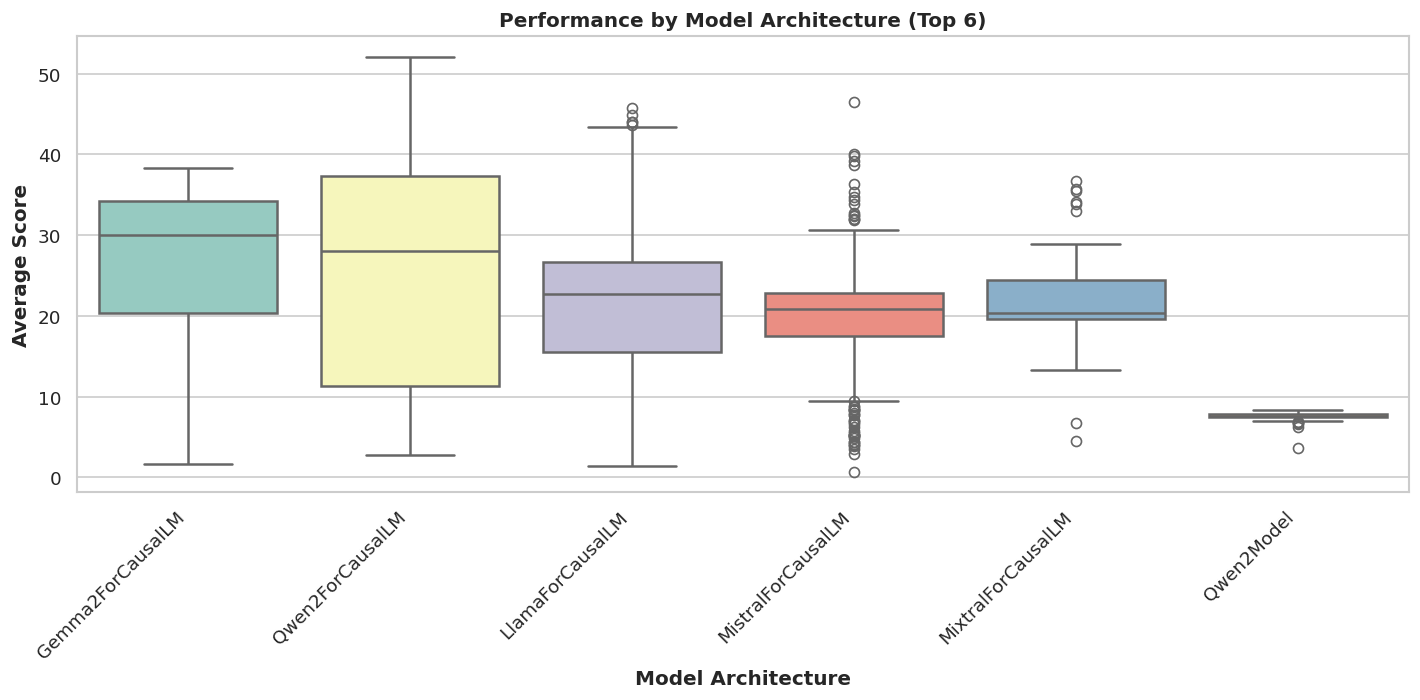

In [23]:
# Get top 6 architectures by count
top_arch = df_clean['Architecture'].value_counts().head(6).index

# Filter to only top architectures
df_top = df_clean[df_clean['Architecture'].isin(top_arch)]


plt.figure(figsize=(12, 6))
# Order by median performance
order_by_values = (
    df_top.groupby('Architecture')['average_score']
    .median()
    .sort_values(ascending=False)
    .index
)

sns.boxplot(
    data=df_top,
    x='Architecture',
    y='average_score',
    order=order_by_values,
    hue='Architecture',                               # map colors to Architecture
    hue_order=order_by_values,                        # keep colors aligned with order
    palette=sns.color_palette("Set3", n_colors=len(order_by_values)),
    dodge=False,                                      # avoid side-by-side splitting
    linewidth=1.5
)

# Bold title and axes
plt.title("Performance by Model Architecture (Top 6)", fontweight="bold")
plt.xlabel("Model Architecture",  fontweight="bold")
plt.ylabel("Average Score", fontweight="bold")
plt.xticks(rotation=45, ha='right')

# Hide redundant legend
plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()


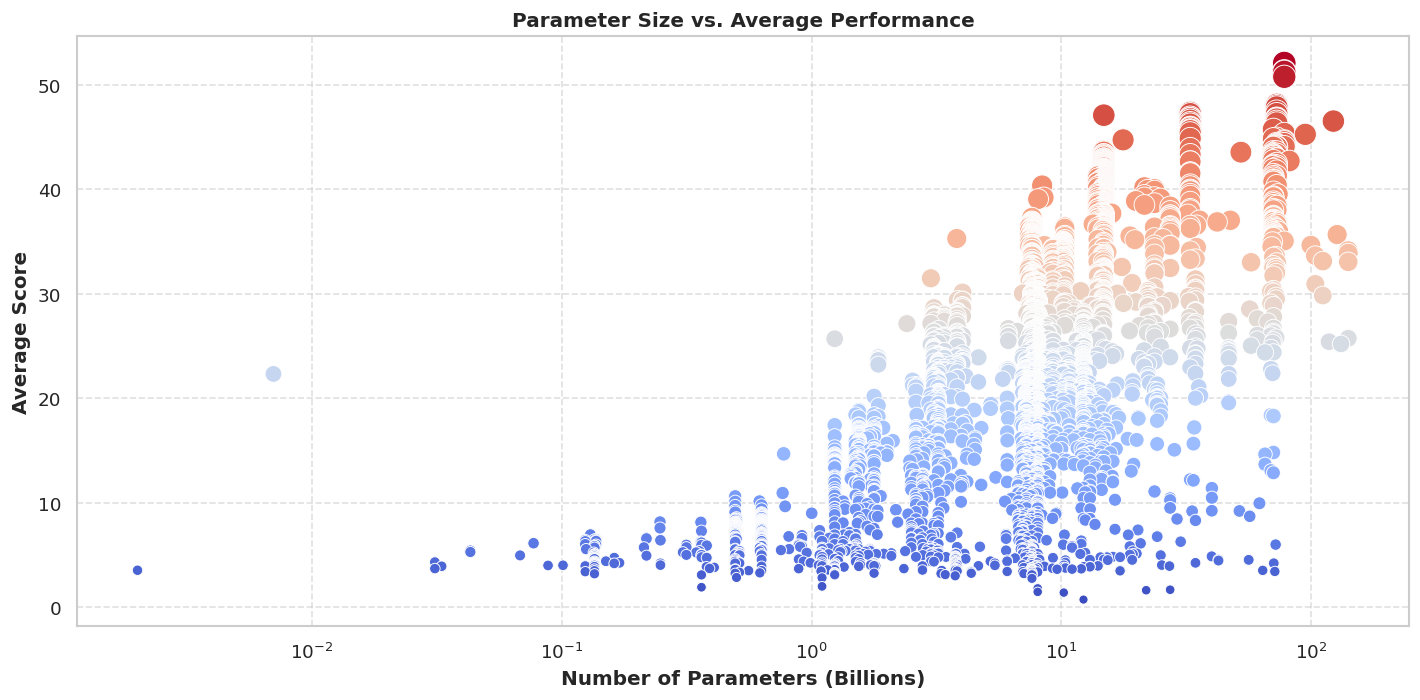

In [24]:
param_perf = open_llm_leaderboard[['#Params (B)', 'Average ⬆️']].dropna()
param_perf = param_perf[param_perf['#Params (B)'] > 0]
plt.figure()
sns.scatterplot(data=param_perf, x='#Params (B)', y='Average ⬆️', hue='Average ⬆️', size='Average ⬆️',
                sizes=(30, 200), palette="coolwarm", legend=False)
plt.title("Parameter Size vs. Average Performance" , fontweight="bold")
plt.xlabel("Number of Parameters (Billions)", fontweight="bold")
plt.ylabel("Average Score", fontweight="bold")
plt.xscale('log')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

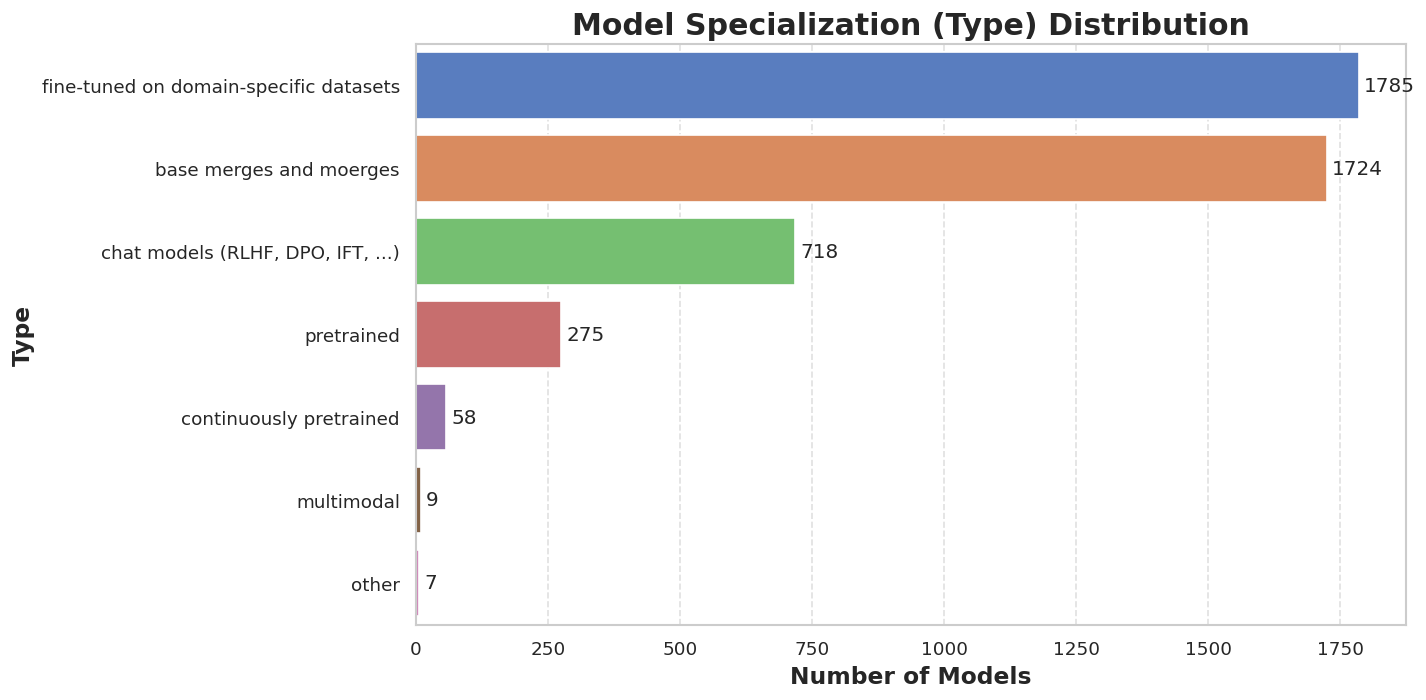

In [25]:
# Data
specialization = open_llm_leaderboard['Type'].value_counts().reset_index()
specialization.columns = ['Type', 'Count']

# Try to use an emoji-capable font; if not found, strip emojis from labels
emoji_fonts = ["Noto Color Emoji", "Noto Emoji", "Segoe UI Emoji", "Apple Color Emoji", "Twemoji Mozilla"]
available_fonts = [f.name for f in fm.fontManager.ttflist]
has_emoji_font = any(any(ef in af for af in available_fonts) for ef in emoji_fonts)
if has_emoji_font:
    # Pick the first available emoji font
    for ef in emoji_fonts:
        if any(ef in af for af in available_fonts):
            plt.rcParams['font.family'] = ef
            break
    specialization['Type_plot'] = specialization['Type']
else:
    # Strip emoji codepoints if no emoji font is available
    emoji_pattern = r'[\U0001F300-\U0001FAFF\U00002700-\U000027BF\U00002600-\U000026FF]'
    specialization['Type_plot'] = specialization['Type'].apply(lambda s: re.sub(emoji_pattern, '', s).strip())

# Plot (fix: add hue to use palette without warning)
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=specialization,
    y='Type_plot', x='Count',
    hue='Type_plot', legend=False, dodge=False,
    palette='muted'
)

# Labels and styling (bold)
plt.title("Model Specialization (Type) Distribution", fontsize=18, fontweight="bold")
plt.xlabel("Number of Models", fontsize=14, fontweight="bold")
plt.ylabel("Type", fontsize=14, fontweight="bold")

# Add x-grid & value labels
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
for c in ax.containers:
    ax.bar_label(c, fmt='%d', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

## 6

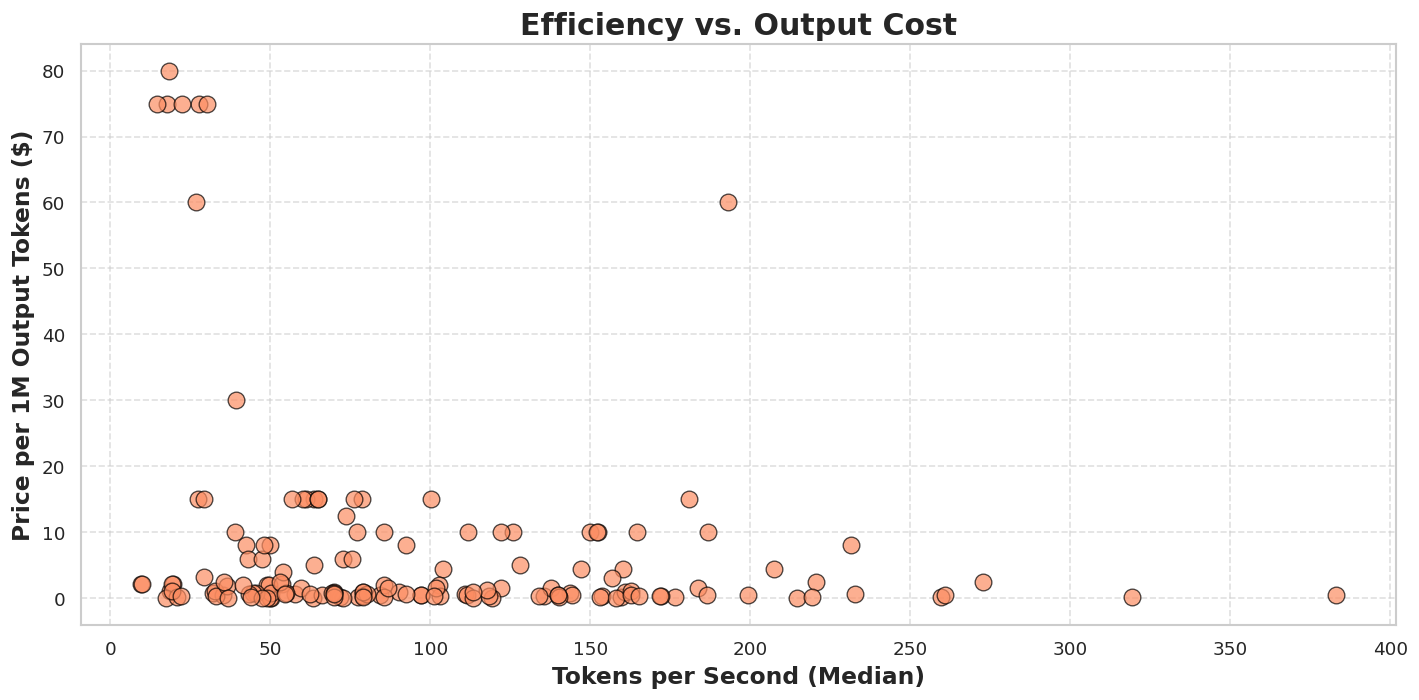

In [26]:
efficiency_cost = llm_models[['median_output_tokens_per_second', 'pricing_price_1m_output_tokens']].dropna()
plt.figure()
sns.scatterplot(data=efficiency_cost,
                x='median_output_tokens_per_second',
                y='pricing_price_1m_output_tokens',
                color=colors[1], s=100, alpha=0.7, edgecolor='black')
plt.title("Efficiency vs. Output Cost", fontsize=18, fontweight="bold")
plt.xlabel("Tokens per Second (Median)", fontsize=14, fontweight="bold")
plt.ylabel("Price per 1M Output Tokens ($)", fontsize=14, fontweight="bold")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## 7

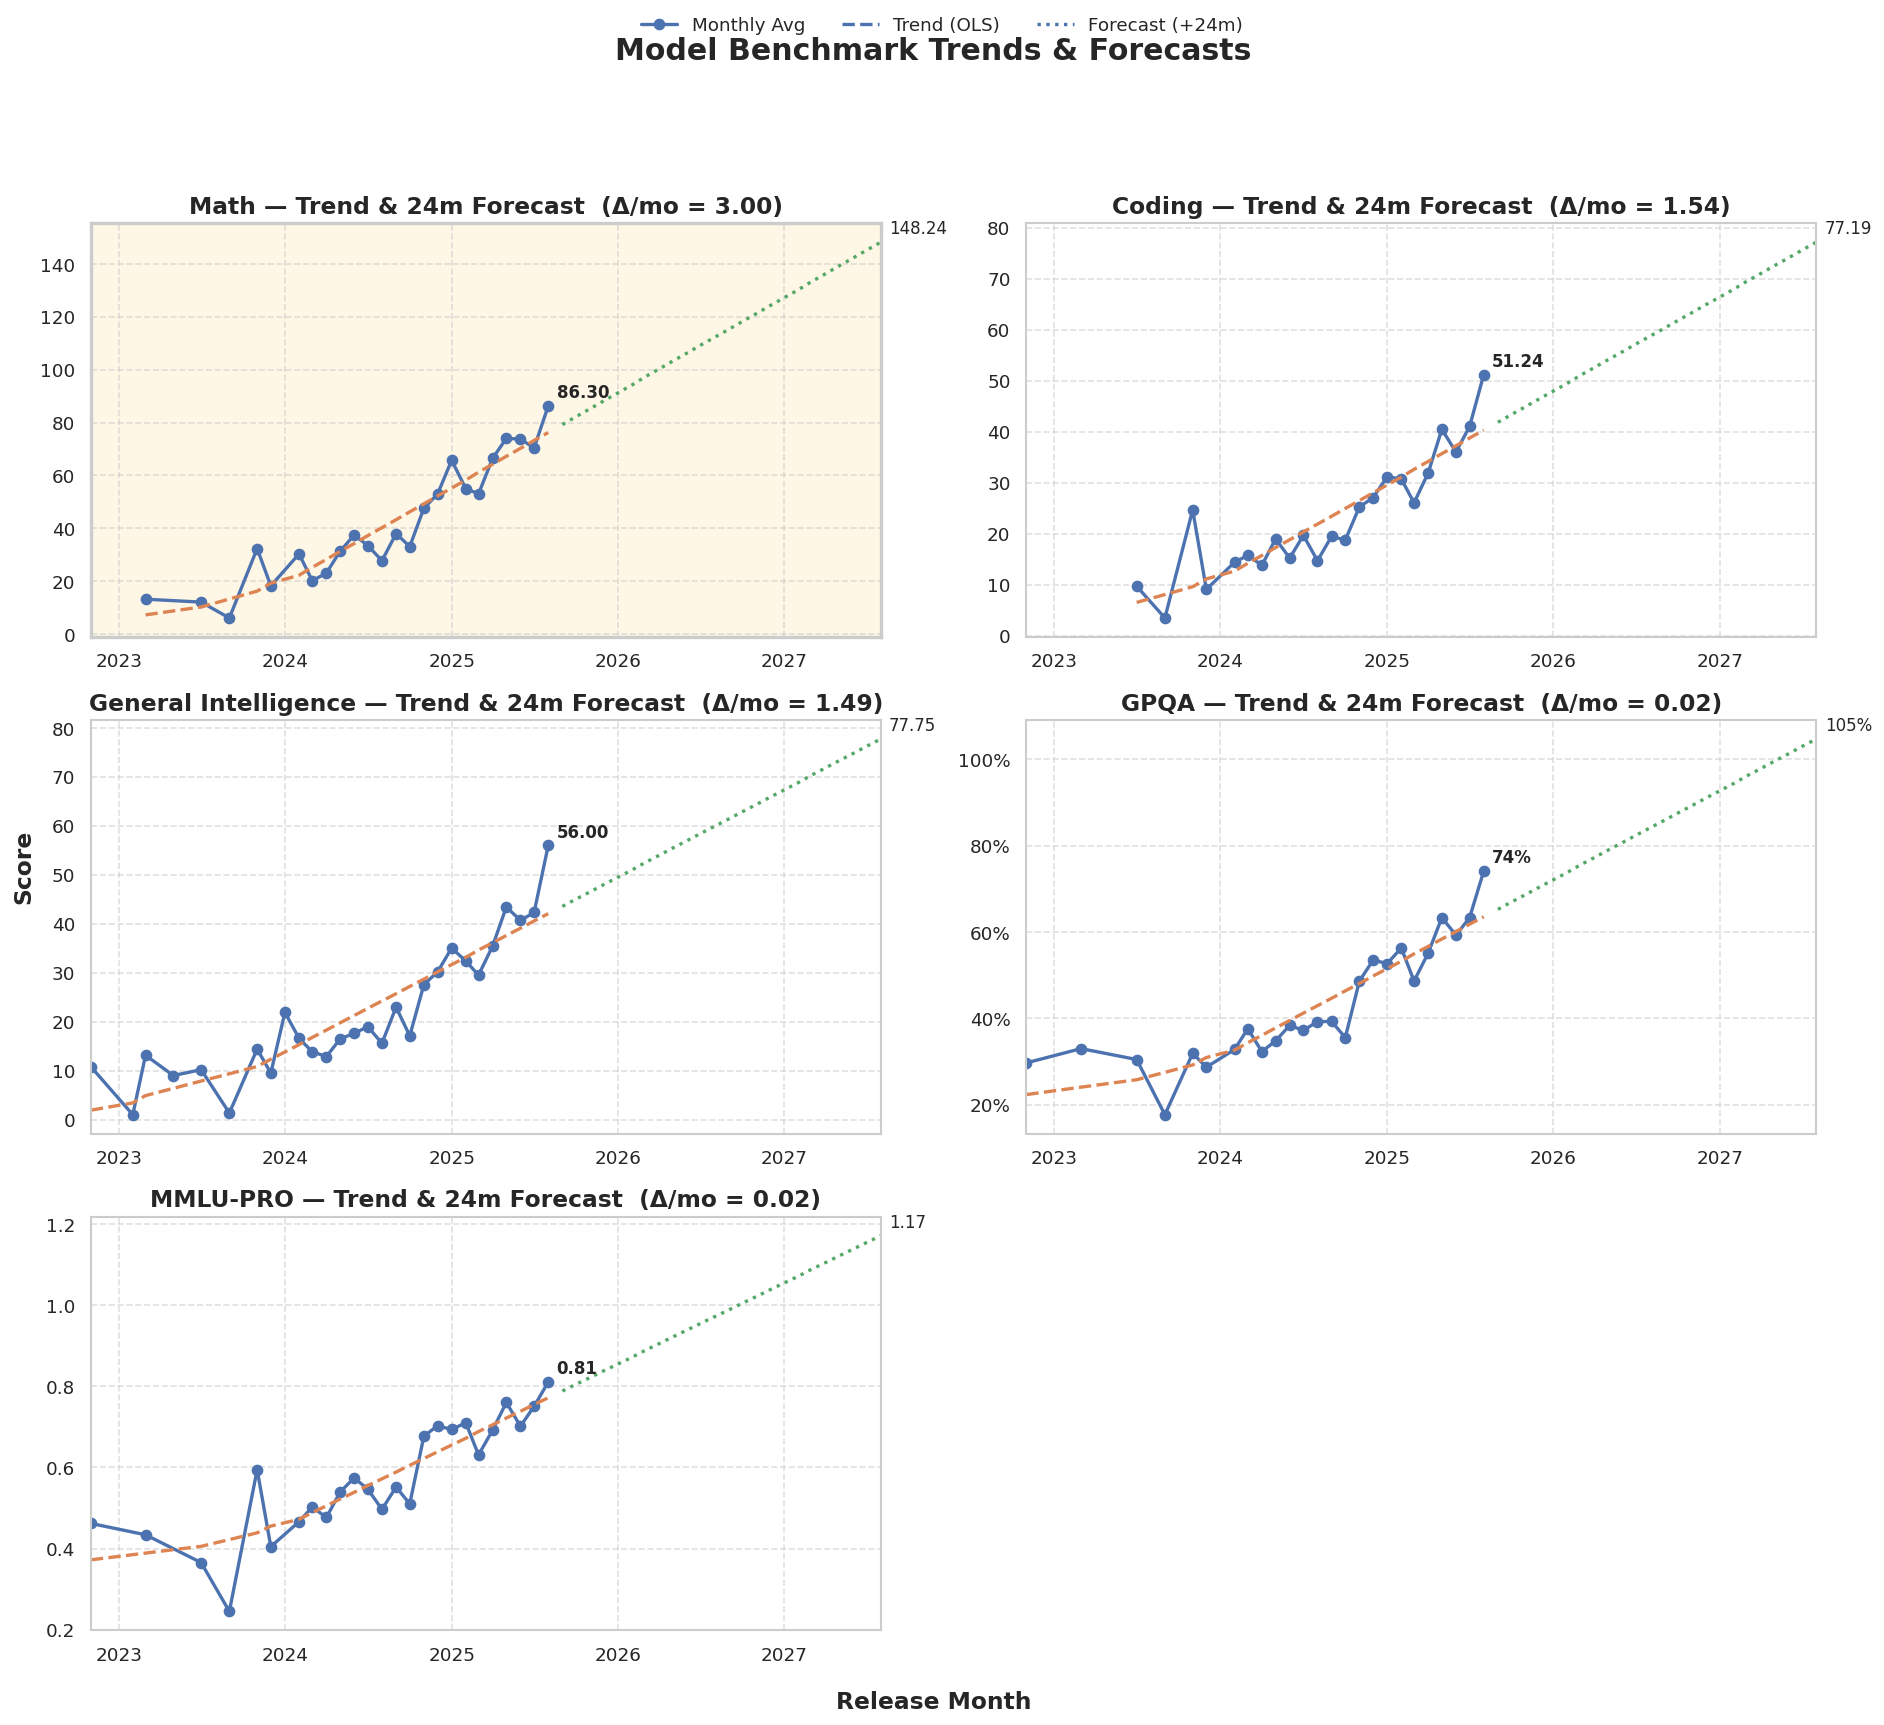

In [27]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.ticker import PercentFormatter
from dateutil.relativedelta import relativedelta

# ==================== CONFIG ====================
HORIZON = 24        # forecast months (set to 12 if you want shorter)
FIG_W   = 16        # total figure width (inches)
ROW_H   = 4.8       # height per row (inches)
NCOLS   = 2         # subplots per row
MAX_XTICKS = 6      # target maximum number of x ticks per subplot
HIGHLIGHT_FACE = '#fff7e6'  # background color for the fastest metric panel
# =================================================

# ---------- Load & Prep ----------
df = llm_models.copy()
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df = df.dropna(subset=['release_date']).copy().sort_values('release_date')

metric_cols = [
    'evaluations_artificial_analysis_intelligence_index',
    'evaluations_artificial_analysis_coding_index',
    'evaluations_artificial_analysis_math_index',
    'evaluations_mmlu_pro',
    'evaluations_gpqa'
]
metric_cols = [c for c in metric_cols if c in df.columns]
for m in metric_cols:
    df[m] = pd.to_numeric(df[m], errors='coerce')

df['release_month'] = df['release_date'].dt.to_period('M').dt.to_timestamp()
monthly = df.groupby('release_month')[metric_cols].mean().reset_index()

# ---------- Friendly metric names ----------
metric_rename = {
    'evaluations_artificial_analysis_intelligence_index': 'General Intelligence',
    'evaluations_artificial_analysis_coding_index': 'Coding',
    'evaluations_artificial_analysis_math_index': 'Math',
    'evaluations_mmlu_pro': 'MMLU-PRO',
    'evaluations_gpqa': 'GPQA'
}

# ---------- Fit + Forecast helper ----------
def fit_and_forecast(ts_df, date_col, value_col, horizon_months=24):
    d = ts_df.dropna(subset=[value_col]).copy()
    if len(d) < 3:
        return None, None, None  # need at least 3 points
    d = d.sort_values(date_col).reset_index(drop=True)
    d['t'] = np.arange(len(d))  # month index
    x = d['t'].values
    y = d[value_col].values
    coeffs = np.polyfit(x, y, 1)      # [slope_per_month, intercept]
    trend = np.poly1d(coeffs)

    # historical
    hist = d.assign(trend=trend(x))

    # future dates & forecasts
    last_date = d[date_col].iloc[-1]
    future_dates = [last_date + relativedelta(months=i+1) for i in range(horizon_months)]
    fut_index = np.arange(len(d), len(d) + horizon_months)
    fut = pd.DataFrame({date_col: future_dates, 'forecast': trend(fut_index)})
    return hist, fut, coeffs

# ---------- Compute results + slopes ----------
results, slopes = {}, {}
for metric in metric_cols:
    hist, fut, coeffs = fit_and_forecast(monthly, 'release_month', metric, horizon_months=HORIZON)
    if hist is None:
        continue
    results[metric] = {'hist': hist, 'fut': fut, 'coeffs': coeffs}
    slopes[metric] = coeffs[0]

# Order panels by slope (desc) and pick the top metric
valid_metrics = sorted(results.keys(), key=lambda m: slopes[m], reverse=True)
if not valid_metrics:
    raise ValueError("No metrics with sufficient data to plot.")
top_metric = valid_metrics[0]
n = len(valid_metrics)

# ---------- Figure & unified x-axis setup ----------
nrows = math.ceil(n / NCOLS)
fig, axes = plt.subplots(nrows=nrows, ncols=NCOLS,
                         figsize=(FIG_W, ROW_H * nrows), squeeze=False)

# same x-limits for all panels (history + forecast horizon)
xmin = monthly['release_month'].min()
xmax_hist = monthly['release_month'].max()
xmax = xmax_hist + pd.offsets.MonthBegin(HORIZON)

# concise, low-density ticks across all panels
locator = mdates.AutoDateLocator(minticks=3, maxticks=MAX_XTICKS)
formatter = mdates.ConciseDateFormatter(locator)  # fewer labels, compact formatting

# ---------- Plot each panel ----------
for i, metric in enumerate(valid_metrics):
    ax   = axes.flat[i]
    hist = results[metric]['hist']
    fut  = results[metric]['fut']
    slope = slopes[metric]
    disp  = metric_rename.get(metric, metric)

    # Lines
    ax.plot(hist['release_month'], hist[metric], 'o-', linewidth=2, label='Monthly Avg')
    ax.plot(hist['release_month'], hist['trend'], '--', linewidth=2, label='Trend (OLS)')
    ax.plot(fut['release_month'],  fut['forecast'], ':',  linewidth=2, label=f'Forecast (+{HORIZON}m)')

    # Decide if values are percentage-like (0..1 range)
    y_all = np.r_[hist[metric].values, fut['forecast'].values]
    perc_like = (np.nanmax(y_all) <= 1.1) and (np.nanmin(y_all) >= -0.05)
    if perc_like:
        ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

    # Annotate last observed & last forecast (format aware)
    last_x, last_y = hist['release_month'].iloc[-1], hist[metric].iloc[-1]
    fut_x,  fut_y  = fut['release_month'].iloc[-1],  fut['forecast'].iloc[-1]
    if perc_like:
        ax.annotate(f"{last_y:.0%}", xy=(last_x, last_y), xytext=(5, 5),
                    textcoords="offset points", fontsize=10, fontweight='bold')
        ax.annotate(f"{fut_y:.0%}",   xy=(fut_x,  fut_y),  xytext=(5, 5),
                    textcoords="offset points", fontsize=10)
    else:
        ax.annotate(f"{last_y:.2f}", xy=(last_x, last_y), xytext=(5, 5),
                    textcoords="offset points", fontsize=10, fontweight='bold')
        ax.annotate(f"{fut_y:.2f}",   xy=(fut_x,  fut_y),  xytext=(5, 5),
                    textcoords="offset points", fontsize=10)

    # Highlight fastest-improving metric
    if metric == top_metric:
        ax.set_facecolor(HIGHLIGHT_FACE)
        for spine in ax.spines.values():
            spine.set_linewidth(2)

    # Title + grid
    ax.set_title(f"{disp} — Trend & {HORIZON}m Forecast  (Δ/mo = {slope:.2f})",
                 fontsize=14, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.6)

    # Apply unified, concise x formatting
    ax.set_xlim(xmin, xmax)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis='x', rotation=0)

# Remove any unused axes
for j in range(i + 1, nrows * NCOLS):
    fig.delaxes(axes.flat[j])

# ---------- Global labels & legend ----------
fig.suptitle("Model Benchmark Trends & Forecasts", fontsize=18, fontweight='bold')
fig.supxlabel("Release Month", fontsize=14, fontweight='bold')
fig.supylabel("Score", fontsize=14, fontweight='bold')

legend_elems = [
    Line2D([0], [0], linestyle='-', marker='o', linewidth=2, label='Monthly Avg'),
    Line2D([0], [0], linestyle='--', linewidth=2, label='Trend (OLS)'),
    Line2D([0], [0], linestyle=':', linewidth=2, label=f'Forecast (+{HORIZON}m)'),
]
fig.legend(handles=legend_elems, loc='upper center', ncol=3, frameon=False, fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.93])  # leave room for suptitle/legend
plt.show()


In [28]:
llm_models.columns

Index(['id', 'name', 'slug', 'release_date', 'median_output_tokens_per_second',
       'median_time_to_first_token_seconds',
       'median_time_to_first_answer_token', 'model_creator_id',
       'model_creator_name', 'model_creator_slug',
       'evaluations_artificial_analysis_intelligence_index',
       'evaluations_artificial_analysis_coding_index',
       'evaluations_artificial_analysis_math_index', 'evaluations_mmlu_pro',
       'evaluations_gpqa', 'evaluations_hle', 'evaluations_livecodebench',
       'evaluations_scicode', 'evaluations_math_500', 'evaluations_aime',
       'evaluations_aime_25', 'evaluations_ifbench', 'evaluations_lcr',
       'pricing_price_1m_blended_3_to_1', 'pricing_price_1m_input_tokens',
       'pricing_price_1m_output_tokens'],
      dtype='object')

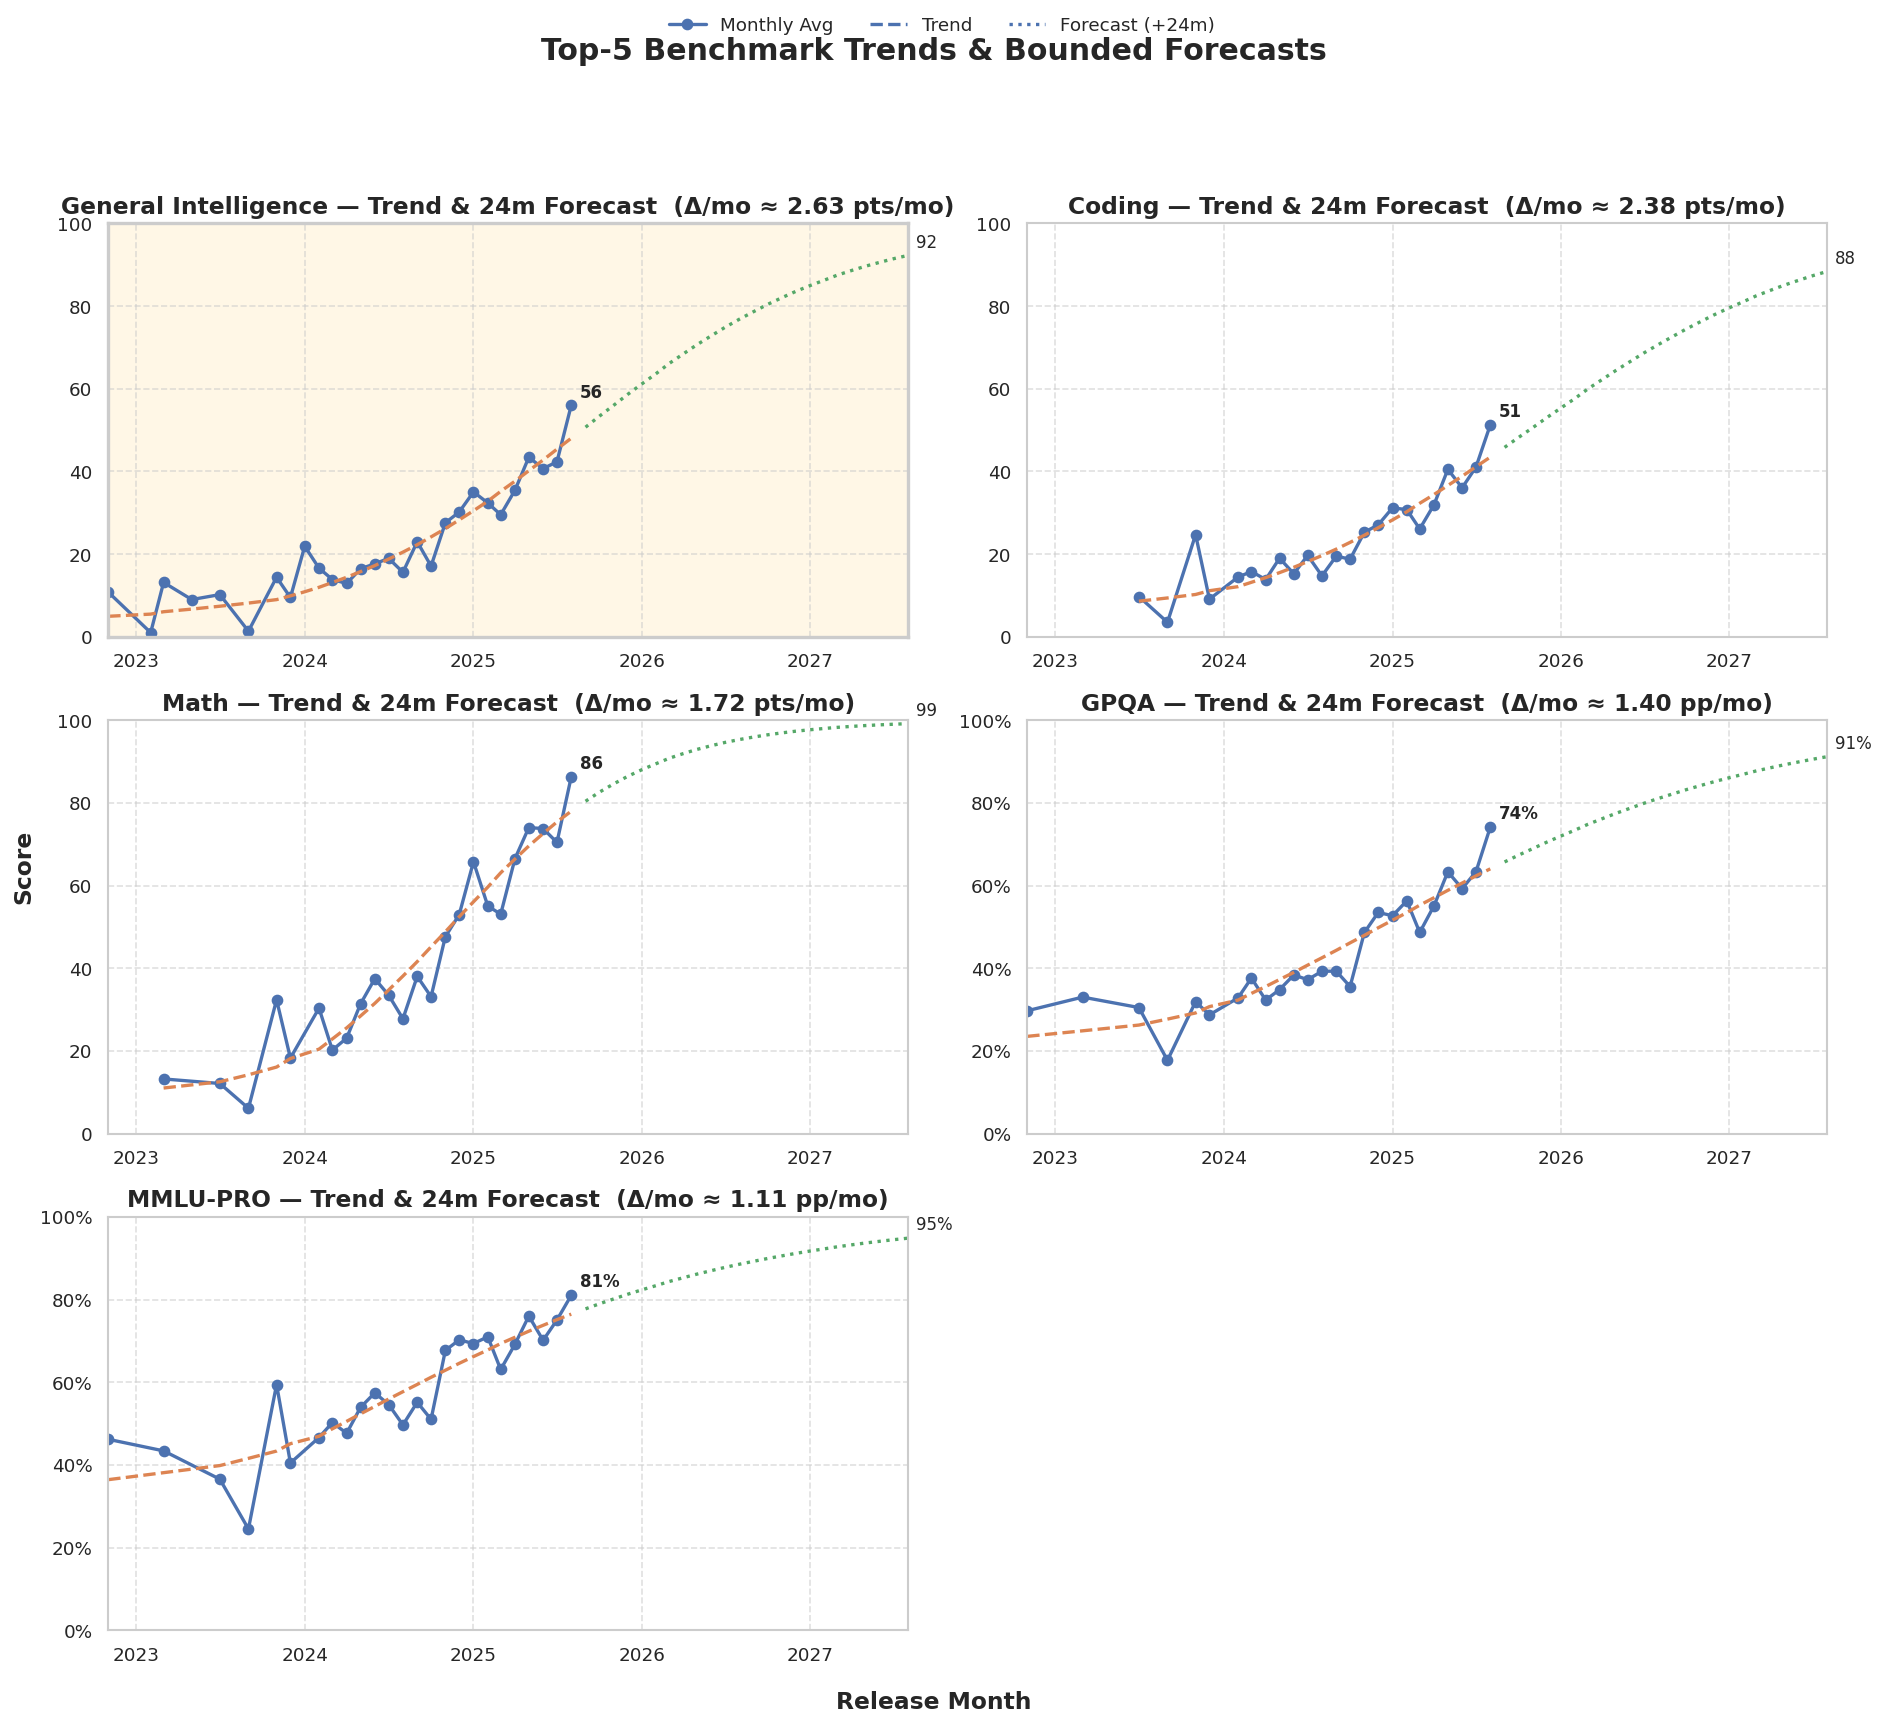

In [29]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.ticker import PercentFormatter
from dateutil.relativedelta import relativedelta

# ==================== CONFIG ====================
HORIZON   = 24         # forecast months (set 12 if you prefer)
NCOLS     = 2          # subplots per row
FIG_W     = 16         # figure width (inches)
ROW_H     = 4.8        # height per row (inches)
MAX_XTICKS= 6          # max x ticks per subplot
MIN_POINTS= 3          # minimum months with data to include a metric
HIGHLIGHT_FACE = '#fff7e6'   # highlight color for fastest panel (None to disable)
ORDER_BY  = 'raw'      # 'raw' (like before) or 'normalized' (fraction of full scale)
# =================================================

# ---------- Data (expects llm_models in memory) ----------
df = llm_models.copy()
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df = df.dropna(subset=['release_date']).copy().sort_values('release_date')

metric_cols = [
    'evaluations_artificial_analysis_intelligence_index',  # 0..100
    'evaluations_artificial_analysis_coding_index',        # 0..100
    'evaluations_artificial_analysis_math_index',          # 0..100
    'evaluations_gpqa',                                    # 0..1
    'evaluations_mmlu_pro'                                 # 0..1
]
metric_cols = [c for c in metric_cols if c in df.columns]
for c in metric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df['release_month'] = df['release_date'].dt.to_period('M').dt.to_timestamp()
monthly = df.groupby('release_month')[metric_cols].mean().reset_index()

# ---------- Pretty names ----------
metric_rename = {
    'evaluations_artificial_analysis_intelligence_index': 'General Intelligence',
    'evaluations_artificial_analysis_coding_index': 'Coding',
    'evaluations_artificial_analysis_math_index': 'Math',
    'evaluations_gpqa': 'GPQA',
    'evaluations_mmlu_pro': 'MMLU-PRO',
}
def pretty(col): return metric_rename.get(col, col)

# ---------- Bounded-forecast helpers ----------
EPS = 1e-6
def logit(p):
    p = np.clip(p, EPS, 1 - EPS)
    return np.log(p / (1 - p))
def inv_logit(z):
    return 1 / (1 + np.exp(-z))
def looks_percent(y):
    y = y[np.isfinite(y)]
    return y.size > 0 and y.min() >= -0.05 and y.max() <= 1.1
def looks_index100(y):
    y = y[np.isfinite(y)]
    return y.size > 0 and y.min() >= -5 and y.max() <= 110 and y.mean() > 1.1

def fit_and_forecast(ts_df, date_col, value_col, horizon_months=24):
    """
    Returns:
      hist (df with 'trend'), fut (df with 'forecast'),
      slope_disp (unit-aware), slope_norm (fraction of full scale / mo)
    """
    d = ts_df.dropna(subset=[value_col]).copy()
    if len(d) < MIN_POINTS: return None, None, None, None
    d = d.sort_values(date_col).reset_index(drop=True)
    d['t'] = np.arange(len(d))
    x = d['t'].values
    y = d[value_col].values

    if looks_percent(y):           # 0..1
        z = logit(y)
        a, b = np.polyfit(x, z, 1)
        trend_y = inv_logit(a * x + b)
        slope_disp = a * y[-1] * (1 - y[-1])                 # fraction/mo
        slope_norm = slope_disp
        fut_idx = np.arange(len(d), len(d) + horizon_months)
        fut_vals = np.clip(inv_logit(a * fut_idx + b), 0, 1)

    elif looks_index100(y):        # 0..100
        y_unit = np.clip(y / 100.0, EPS, 1 - EPS)
        z = logit(y_unit)
        a, b = np.polyfit(x, z, 1)
        trend_y = inv_logit(a * x + b) * 100.0
        slope_pts = a * y_unit[-1] * (1 - y_unit[-1]) * 100.0  # pts/mo
        slope_disp = slope_pts
        slope_norm = slope_pts / 100.0
        fut_idx = np.arange(len(d), len(d) + horizon_months)
        fut_vals = np.clip(inv_logit(a * fut_idx + b), 0, 1) * 100.0

    else:                          # linear fallback
        a, b = np.polyfit(x, y, 1)
        trend_y = a * x + b
        slope_disp = a
        slope_norm = np.nan
        fut_idx = np.arange(len(d), len(d) + horizon_months)
        fut_vals = a * fut_idx + b

    hist = d.assign(trend=trend_y)
    last_date = d[date_col].iloc[-1]
    future_dates = [last_date + relativedelta(months=i+1) for i in range(horizon_months)]
    fut = pd.DataFrame({date_col: future_dates, 'forecast': fut_vals})
    return hist, fut, slope_disp, slope_norm

# ---------- Fit & collect ----------
results = {}
for m in metric_cols:
    hist, fut, slope_disp, slope_norm = fit_and_forecast(monthly, 'release_month', m, HORIZON)
    if hist is not None:
        results[m] = {'hist': hist, 'fut': fut,
                      'slope_disp': slope_disp, 'slope_norm': slope_norm}

valid = list(results.keys())
if not valid:
    raise ValueError("No metrics have enough data to plot.")

# order & highlight
if ORDER_BY == 'normalized':
    valid.sort(key=lambda m: (-(results[m]['slope_norm']
                               if np.isfinite(results[m]['slope_norm']) else -np.inf)))
else:  # 'raw' like before
    valid.sort(key=lambda m: -results[m]['slope_disp'])

top_metric = valid[0]

# ---------- Figure & unified x-axis ----------
n = len(valid)
nrows = math.ceil(n / NCOLS)
fig, axes = plt.subplots(nrows=nrows, ncols=NCOLS,
                         figsize=(FIG_W, ROW_H * nrows), squeeze=False)

xmin = monthly['release_month'].min()
xmax_hist = monthly['release_month'].max()
xmax = xmax_hist + pd.offsets.MonthBegin(HORIZON)

locator = mdates.AutoDateLocator(minticks=3, maxticks=MAX_XTICKS)
formatter = mdates.ConciseDateFormatter(locator)

# ---------- Plot ----------
for i, m in enumerate(valid):
    ax   = axes.flat[i]
    hist = results[m]['hist']
    fut  = results[m]['fut']
    sraw = results[m]['slope_disp']
    snrm = results[m]['slope_norm']
    name = pretty(m)

    ax.plot(hist['release_month'], hist[m], 'o-', linewidth=2, label='Monthly Avg')
    ax.plot(hist['release_month'], hist['trend'], '--', linewidth=2, label='Trend')
    ax.plot(fut['release_month'],  fut['forecast'], ':',  linewidth=2, label=f'Forecast (+{HORIZON}m)')

    # scale-aware labels/limits
    y_all = np.r_[hist[m].values, fut['forecast'].values]
    is_pct = looks_percent(y_all)
    is_100 = (not is_pct) and looks_index100(y_all)

    if is_pct:
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
        ann_last = f"{hist[m].iloc[-1]:.0%}"
        ann_fut  = f"{fut['forecast'].iloc[-1]:.0%}"
        slope_label = f"{sraw*100:.2f} pp/mo"
    elif is_100:
        ax.set_ylim(0, 100)
        ann_last = f"{hist[m].iloc[-1]:.0f}"
        ann_fut  = f"{fut['forecast'].iloc[-1]:.0f}"
        slope_label = f"{sraw:.2f} pts/mo"
    else:
        ann_last = f"{hist[m].iloc[-1]:.2f}"
        ann_fut  = f"{fut['forecast'].iloc[-1]:.2f}"
        slope_label = f"{sraw:.2f} /mo"

    ax.annotate(ann_last, xy=(hist['release_month'].iloc[-1], hist[m].iloc[-1]),
                xytext=(5, 5), textcoords="offset points", fontsize=10, fontweight='bold')
    ax.annotate(ann_fut,  xy=(fut['release_month'].iloc[-1],  fut['forecast'].iloc[-1]),
                xytext=(5, 5), textcoords="offset points", fontsize=10)

    if m == top_metric and HIGHLIGHT_FACE:
        ax.set_facecolor(HIGHLIGHT_FACE)
        for spine in ax.spines.values():
            spine.set_linewidth(2)

    ax.set_title(f"{name} — Trend & {HORIZON}m Forecast  (Δ/mo ≈ {slope_label})",
                 fontsize=14, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.6)

    ax.set_xlim(xmin, xmax)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis='x', rotation=0)

# remove unused subplots (if any)
for j in range(i + 1, nrows * NCOLS):
    fig.delaxes(axes.flat[j])

# ---------- Global labels & legend ----------
fig.suptitle("Top-5 Benchmark Trends & Bounded Forecasts", fontsize=18, fontweight='bold')
fig.supxlabel("Release Month", fontsize=14, fontweight='bold')
fig.supylabel("Score", fontsize=14, fontweight='bold')

legend_elems = [
    Line2D([0], [0], linestyle='-', marker='o', linewidth=2, label='Monthly Avg'),
    Line2D([0], [0], linestyle='--', linewidth=2, label='Trend'),
    Line2D([0], [0], linestyle=':', linewidth=2, label=f'Forecast (+{HORIZON}m)'),
]
fig.legend(handles=legend_elems, loc='upper center', ncol=3, frameon=False, fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("top5_benchmarks_trend_forecast.png", dpi=150)
plt.show()


# Algorithms

## Kmeans

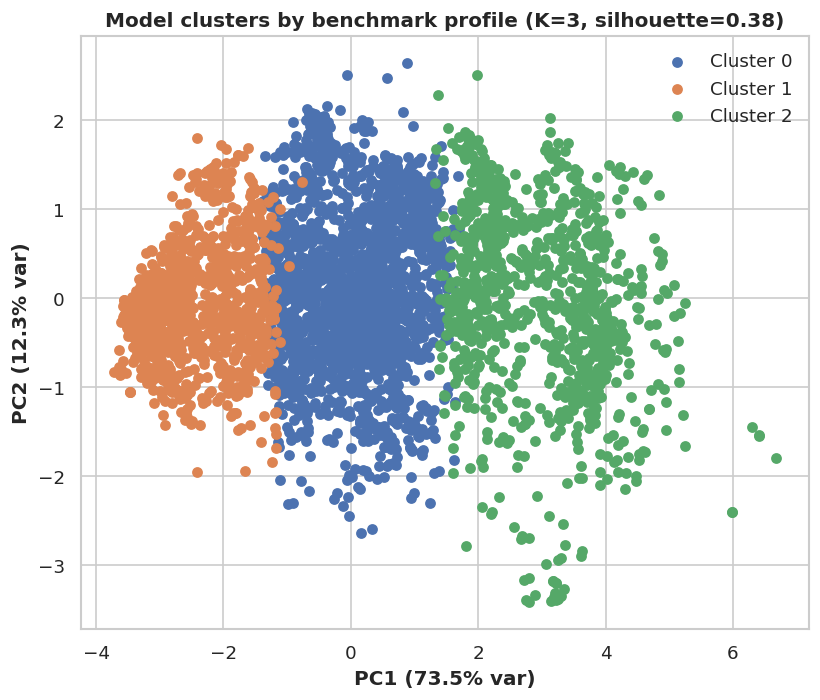

,z_IFEval,z_BBH,z_MATH Lvl 5,z_GPQA,z_MUSR,z_MMLU-PRO,cluster
0,0.177153,0.135503,-0.213920,-0.084605,0.066298,0.130879,0
1,-0.985407,-1.264156,-0.797586,-0.951720,-0.972207,-1.274398,1
2,0.824548,1.256832,1.442409,1.350994,1.048806,1.279425,2


In [30]:
# --- CONFIG: pick the benchmark columns you have ---
METRICS = ["IFEval", "BBH", "MATH Lvl 5", "GPQA", "MUSR", "MMLU-PRO"]  # adjust if needed

import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

df = open_llm_leaderboard.copy()

dfm = df.dropna(subset=METRICS).copy()

X = dfm[METRICS].values
Xz = StandardScaler().fit_transform(X)

# Choose K automatically (2..6) via silhouette
best = {"k":None, "score":-1, "model":None}
for k in range(2, 7):
    km = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(Xz)
    s  = silhouette_score(Xz, km.labels_)
    if s > best["score"]:
        best = {"k":k, "score":s, "model":km}

dfm["cluster"] = best["model"].labels_

# 2D PCA for visualization
pca = PCA(n_components=2, random_state=42).fit(Xz)
P   = pca.transform(Xz)

plt.figure(figsize=(7,6))
for c in sorted(dfm["cluster"].unique()):
    sel = dfm["cluster"]==c
    plt.scatter(P[sel,0], P[sel,1], s=30, label=f"Cluster {c}")
plt.title(f"Model clusters by benchmark profile (K={best['k']}, silhouette={best['score']:.2f})", fontweight="bold")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)", fontweight="bold")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)", fontweight="bold")
plt.legend(frameon=False); plt.tight_layout()
plt.show()

# Quick cluster centroids (which skills each cluster is high/low on)
centroids = pd.DataFrame(StandardScaler().fit(METRICS=np.arange(len(METRICS))) if False else best["model"].cluster_centers_,
                         columns=[f"z_{m}" for m in METRICS])
display(centroids.assign(cluster=np.arange(best["k"])))


## CHANGE-POINT DETECTION

/tmp/ipython-input-1994887717.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  llm = pd.read_csv("llm_models.csv", parse_dates=["release_date"], dayfirst=False, infer_datetime_format=True)


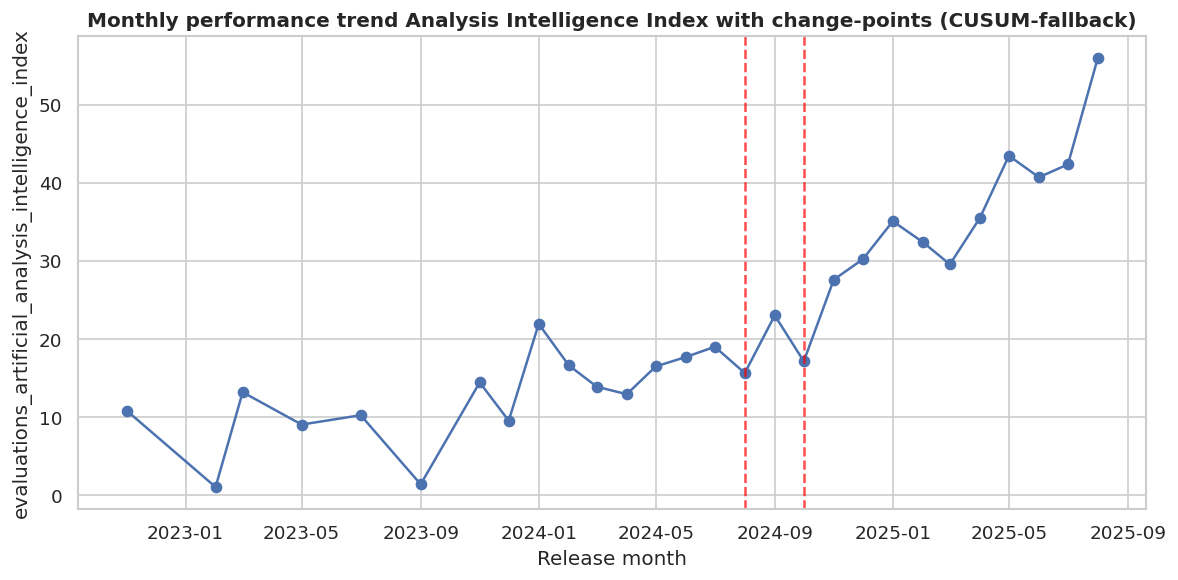

Detected change-points at: ['2024-08-01', '2024-10-01']


In [31]:
# === CHANGE-POINT DETECTION (with fallback) ===
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

llm = pd.read_csv("llm_models.csv", parse_dates=["release_date"], dayfirst=False, infer_datetime_format=True)
llm = llm.dropna(subset=["release_date"]).copy()
llm["release_month"] = llm["release_date"].dt.to_period("M").dt.to_timestamp()

# Pick a performance series (broader coverage)
perf_candidates = [
    "evaluations_artificial_analysis_intelligence_index",
    "evaluations_artificial_analysis_coding_index",
    "evaluations_artificial_analysis_math_index",
    "evaluations_mmlu_pro",
    "evaluations_gpqa",
    "evaluations_hle",
]
avail = [c for c in perf_candidates if c in llm.columns]
if not avail:
    raise ValueError("No performance columns found in llm_models.csv for change-point analysis.")
perf_col = max(avail, key=lambda c: llm[c].notna().sum())

# Monthly mean performance
trend = (llm.dropna(subset=[perf_col])
            .groupby("release_month")[perf_col]
            .mean()
            .sort_index())

y = trend.values.astype(float)

# Try ruptures; fallback to simple CUSUM if not available
change_idxs = []
try:
    import ruptures as rpt
    model = rpt.Pelt(model="rbf").fit(y)
    # Penalty tuned lightly; you can tweak pen for more/less segments
    change_idxs = model.predict(pen=5)  # returns the end index of each segment
    change_idxs = [i-1 for i in change_idxs if i-1 >= 0 and i-1 < len(y)]
    method_used = "ruptures-PELT"
except Exception:
    # Simple CUSUM: detect top-2 changes in cumulative deviation
    mu = y.mean()
    cusum = np.cumsum(y - mu)
    # pick local extrema excluding ends
    k = min(2, max(0, len(cusum)-2))
    if k > 0:
        # indices of largest absolute deviations (excluding first/last)
        mid = cusum[1:-1]
        idxs = np.argsort(np.abs(mid))[-k:] + 1
        change_idxs = sorted(idxs.tolist())
    method_used = "CUSUM-fallback"

# Plot with change points
t = trend.index
plt.figure(figsize=(10,5))
plt.plot(t, y, marker="o", lw=1.5)
for ci in change_idxs:
    plt.axvline(t[ci], color="red", linestyle="--", alpha=0.7)
plt.title(f"Monthly performance trend Analysis Intelligence Index with change-points ({method_used})", fontweight="bold")
plt.xlabel("Release month"); plt.ylabel(perf_col)
plt.tight_layout(); plt.show()

# Print detected dates
detected_dates = [t[i].date().isoformat() for i in change_idxs]
print("Detected change-points at:", detected_dates)


## XGBoostClassifier

In [44]:
# Multiclass XGBoost + SHAP with LabelEncoder for y (version-robust)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
try:
    from xgboost import callback as xgb_cb  # for early stopping across versions
except Exception:
    xgb_cb = None

import shap

# ----------------- CONFIG -----------------
CSV_PATH = "llm_models.csv"
TARGET_COL = "model_creator_name"
MIN_SAMPLES_PER_CLASS = 3
TEST_SIZE = 0.2
RANDOM_STATE = 42
OUTDIR = "xgb_multiclass_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# ----------------- LOAD -------------------
df = pd.read_csv(CSV_PATH)

# Parse date-like columns
for c in df.columns:
    if "date" in c.lower():
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Require target
df = df.dropna(subset=[TARGET_COL]).copy()
df[TARGET_COL] = df[TARGET_COL].astype(str)

# ----------------- RARE CLASSES -----------
vc = df[TARGET_COL].value_counts()
keepers = vc[vc >= MIN_SAMPLES_PER_CLASS].index
if len(keepers) < 2:
    keepers = vc[vc >= 2].index  # fallback

df = df[df[TARGET_COL].isin(keepers)].copy()
if df[TARGET_COL].nunique() < 2:
    raise ValueError("Not enough classes after filtering. Lower MIN_SAMPLES_PER_CLASS or add more data.")

# ----------------- FEATURES ---------------
exclude_cols = {
    TARGET_COL, "model_creator_id", "model_creator_slug",
    "name", "slug", "Model", "fullname", "Model sha",
    "Base Model", "Official Providers", "Available on the hub"
}

feature_cols = [c for c in df.columns if c not in exclude_cols]

def is_constant(s: pd.Series) -> bool:
    vals = s.dropna().unique()
    return len(vals) <= 1

feature_cols = [c for c in feature_cols if not df[c].isna().all() and not is_constant(df[c])]

# Convert datetimes to numeric
for c in feature_cols:
    if pd.api.types.is_datetime64_any_dtype(df[c]):
        df[c] = df[c].view("int64")

numeric_cols, categorical_cols = [], []
for c in feature_cols:
    if pd.api.types.is_numeric_dtype(df[c]):
        numeric_cols.append(c)
    else:
        categorical_cols.append(c)

X = df[feature_cols].copy()
y_text = df[TARGET_COL].copy()

# ----------------- LABEL ENCODE y ----------
le = LabelEncoder()
y = le.fit_transform(y_text)  # y is now integer-encoded
class_names = list(le.classes_)  # keep for reports/plots
num_classes = len(class_names)

# Optional: save mapping for reference
pd.DataFrame({"class_id": np.arange(num_classes), "class_name": class_names}) \
  .to_csv(os.path.join(OUTDIR, "label_mapping.csv"), index=False)

# ----------------- SPLIT ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# ----------------- PREPROCESS -------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler(with_mean=False))  # safe with sparse
])

# sklearn >=1.2 uses sparse_output; older used sparse
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    sparse_threshold=1.0
)

X_train_tx = preprocess.fit_transform(X_train)
X_test_tx  = preprocess.transform(X_test)

# Build feature names for SHAP
if len(categorical_cols):
    oh = preprocess.named_transformers_["cat"].named_steps["onehot"]
    cat_expanded = oh.get_feature_names_out(categorical_cols)
else:
    cat_expanded = np.array([])

feature_names = list(numeric_cols) + list(cat_expanded)

# ----------------- MODEL ------------------
xgb = XGBClassifier(
    n_estimators=700,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="multi:softprob",
    num_class=num_classes,
    tree_method="hist",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="mlogloss",  # in constructor for >=2.0; harmless earlier
)

# Early stopping via callbacks (works across versions); fall back if unsupported
fit_kwargs = {"eval_set": [(X_train_tx, y_train), (X_test_tx, y_test)], "verbose": False}
if xgb_cb is not None:
    fit_kwargs["callbacks"] = [xgb_cb.EarlyStopping(rounds=50, metric_name="mlogloss", save_best=True)]

try:
    xgb.fit(X_train_tx, y_train, **fit_kwargs)
except TypeError:
    fit_kwargs.pop("callbacks", None)
    xgb.fit(X_train_tx, y_train, **fit_kwargs)

# ----------------- EVAL -------------------
y_pred_int = xgb.predict(X_test_tx)
y_pred_text = le.inverse_transform(y_pred_int)     # back to names
y_test_text = le.inverse_transform(y_test)

report = classification_report(y_test_text, y_pred_text, labels=class_names, zero_division=0)
with open(os.path.join(OUTDIR, "classification_report.txt"), "w", encoding="utf-8") as f:
    f.write(report)
print("\nClassification report:\n", report)

/tmp/ipython-input-748433622.py:71: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df[c] = df[c].view("int64")



Classification report:
                  precision    recall  f1-score   support

      AI21 Labs       0.00      0.00      0.00         1
        Alibaba       0.40      0.57      0.47         7
         Amazon       0.00      0.00      0.00         1
      Anthropic       1.00      0.67      0.80         3
         Cohere       1.00      1.00      1.00         1
       DeepSeek       0.25      0.50      0.33         4
         Google       0.33      0.29      0.31         7
           Meta       0.50      0.67      0.57         3
Microsoft Azure       0.00      0.00      0.00         1
        MiniMax       0.00      0.00      0.00         0
        Mistral       0.80      0.67      0.73         6
         NVIDIA       0.50      0.50      0.50         2
  Nous Research       0.00      0.00      0.00         0
         OpenAI       0.75      0.43      0.55         7
     Perplexity       0.00      0.00      0.00         1
        Reka AI       1.00      1.00      1.00         1
     

In [48]:
# ================== SHAP: Explainability ==================
import scipy.sparse as sp
import warnings

os.makedirs(os.path.join(OUTDIR, "shap"), exist_ok=True)

# Convert test matrix to dense only if small; SHAP + TreeExplainer works with sparse CSR.
X_test_tx_csr = X_test_tx if sp.issparse(X_test_tx) else sp.csr_matrix(X_test_tx)

# Helper: unify multiclass outputs across SHAP versions
def _compute_shap_values_multiclass(model, X_csr):
    explainer = shap.TreeExplainer(model)
    sv = explainer.shap_values(X_csr)
    # Possibilities:
    # 1) list of length num_classes, each (n_samples, n_features)
    # 2) ndarray (n_samples, n_features, num_classes)
    if isinstance(sv, list):
        # list[cls] -> array
        sv_arr = np.stack(sv, axis=-1)  # (n_samples, n_features, num_classes)
    else:
        sv_arr = sv  # already 3D
        if sv_arr.ndim == 2:
            # binary case sometimes returns (n_samples, n_features); expand last dim
            sv_arr = sv_arr[..., np.newaxis]
    return sv_arr, explainer

shap_values_3d, explainer = _compute_shap_values_multiclass(xgb, X_test_tx_csr)  # (n, p, K)
n_samples, n_features, K = shap_values_3d.shape

# ----------------- Global importance: overall & per class -----------------
# Overall: mean over classes of mean |SHAP|
mean_abs_shap_per_feat_per_class = np.mean(np.abs(shap_values_3d), axis=0)  # (p, K)
mean_abs_shap_overall = np.mean(mean_abs_shap_per_feat_per_class, axis=1)  # (p,)

glob_imp_df = (pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap_overall": mean_abs_shap_overall
    })
    .sort_values("mean_abs_shap_overall", ascending=False)
    .reset_index(drop=True))
glob_imp_df.to_csv(os.path.join(OUTDIR, "shap", "global_importance_overall.csv"), index=False)

# Per-class importances (which features push class c, on average)
per_class_list = []
for c in range(K):
    per_class = mean_abs_shap_per_feat_per_class[:, c]
    tmp = (pd.DataFrame({
            "class_id": c,
            "class_name": class_names[c],
            "feature": feature_names,
            "mean_abs_shap": per_class
        })
        .sort_values("mean_abs_shap", ascending=False)
        .reset_index(drop=True))
    tmp.to_csv(os.path.join(OUTDIR, "shap", f"importance_class_{c}_{class_names[c]}.csv"), index=False)
    per_class_list.append(tmp)

# ----------------- Group OHE columns back to original feature names -----------------
def group_one_hot_importance(feature_names_list, values):
    """
    Sum importance of one-hot expanded columns back to their original feature.
    Works with scikit's get_feature_names_out format: e.g. 'cat__Architecture_MoE' or 'Architecture_MoE'
    """
    grouped = {}
    for fname, val in zip(feature_names_list, values):
        # try to strip ColumnTransformer prefixes
        base = fname
        if "__" in base:
            base = base.split("__", 1)[1]
        # for OneHotEncoder, pattern is 'FeatureName_Category'
        # we group by the part before the first underscore only if that base indeed comes from a categorical col
        if "_" in base and base.split("_")[0] in categorical_cols:
            key = base.split("_")[0]
        else:
            key = base
        grouped[key] = grouped.get(key, 0.0) + float(val)
    return (pd.DataFrame({"group": list(grouped.keys()), "sum_mean_abs_shap": list(grouped.values())})
              .sort_values("sum_mean_abs_shap", ascending=False)
              .reset_index(drop=True))

group_overall = group_one_hot_importance(feature_names, mean_abs_shap_overall)
group_overall.to_csv(os.path.join(OUTDIR, "shap", "global_importance_overall_GROUPED.csv"), index=False)

# Per-class grouped (optional but useful)
for c in range(K):
    grp_c = group_one_hot_importance(feature_names, mean_abs_shap_per_feat_per_class[:, c])
    grp_c.to_csv(os.path.join(OUTDIR, "shap", f"importance_class_{c}_{class_names[c]}_GROUPED.csv"), index=False)

# ----------------- Plots: Global bar plots (overall and per-class) -----------------
plt.figure(figsize=(8, 8))
top_k = 25
to_plot = glob_imp_df.head(top_k)
plt.barh(to_plot["feature"][::-1], to_plot["mean_abs_shap_overall"][::-1])
plt.title("Global importance (mean |SHAP| across classes)")
plt.xlabel("mean |SHAP|")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "shap", "global_importance_overall_top25.png"), dpi=200)
plt.close()

# Per-class bars
for c in range(K):
    imp_c = per_class_list[c].head(top_k)
    plt.figure(figsize=(8, 8))
    plt.barh(imp_c["feature"][::-1], imp_c["mean_abs_shap"][::-1])
    plt.title(f"Class-specific importance: {class_names[c]}")
    plt.xlabel("mean |SHAP| (class-specific)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "shap", f"importance_class_{c}_{class_names[c]}_top25.png"), dpi=200)
    plt.close()

# ----------------- SHAP summary plots (if feasible) -----------------
# For multiclass, SHAP's summary_plot expects a 2D array; we can aggregate across classes:
shap_2d_overall = np.mean(np.abs(shap_values_3d), axis=2) * np.sign(np.mean(shap_values_3d, axis=2))
# Note: this "signed mean" is a heuristic to keep directionality; feel free to change to pure |SHAP| if preferred.

try:
    # SHAP supports sparse masks; convert a small sample to avoid huge scatter draws
    sample_idx = np.random.RandomState(RANDOM_STATE).choice(np.arange(n_samples), size=min(1000, n_samples), replace=False)
    shap.summary_plot(
        shap_2d_overall[sample_idx],  # (n_samp, p)
        X_test_tx_csr[sample_idx],
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "shap", "summary_bar_overall.png"), dpi=200, bbox_inches="tight")
    plt.close()

    shap.summary_plot(
        shap_2d_overall[sample_idx],
        X_test_tx_csr[sample_idx],
        feature_names=feature_names,
        show=False
    )
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "shap", "summary_dot_overall.png"), dpi=200, bbox_inches="tight")
    plt.close()
except Exception as e:
    warnings.warn(f"SHAP summary_plot skipped: {e}")

# ----------------- Instance-level waterfall: one correct & one misclassified -----------------
# find one correct and one wrong prediction if possible
correct_mask = (y_pred_int == y_test)
wrong_mask = ~correct_mask

def _pick_index(mask):
    idx = np.where(mask)[0]
    if len(idx) == 0:
        return None
    # pick a deterministic example
    return idx[0]

idx_correct = _pick_index(correct_mask)
idx_wrong   = _pick_index(wrong_mask)

# Class-conditional SHAP values for a single sample:
def plot_waterfall_for_sample(idx, chosen_class=None, tag="sample"):
    """
    idx: index in the test set arrays
    chosen_class: if None, use predicted class; else use specific class id for the waterfall
    """
    if idx is None:
        return
    xrow = X_test_tx_csr[idx].toarray().ravel() if sp.issparse(X_test_tx_csr) else np.asarray(X_test_tx_csr[idx]).ravel()
    pred_probs = xgb.predict_proba(X_test_tx[idx])[0] if not sp.issparse(X_test_tx) else xgb.predict_proba(X_test_tx_csr[idx])[0]
    pred_cls = int(np.argmax(pred_probs))
    if chosen_class is None:
        chosen_class = pred_cls

    shap_vals_row = shap_values_3d[idx, :, chosen_class]  # (p,)
    base_value = explainer.expected_value
    # expected_value can be per-class list/array
    if isinstance(base_value, (list, tuple, np.ndarray)):
        base = np.array(base_value).reshape(-1)[chosen_class]
    else:
        base = float(base_value)

    # Build a small SHAP Explanation object if available (newer SHAP)
    try:
        exp = shap.Explanation(
            values=shap_vals_row,
            base_values=base,
            data=xrow,
            feature_names=feature_names
        )
        fig = shap.plots.waterfall(exp, max_display=20, show=False)
        plt.title(f"Waterfall • idx={idx} • class={class_names[chosen_class]}")
        outp = os.path.join(OUTDIR, "shap", f"waterfall_{tag}_class_{chosen_class}_{class_names[chosen_class]}.png")
        plt.tight_layout()
        plt.savefig(outp, dpi=200, bbox_inches="tight")
        plt.close()
    except Exception:
        # fallback: manual top-k bar if waterfall not available
        top_idx = np.argsort(np.abs(shap_vals_row))[-20:]
        plt.figure(figsize=(8, 8))
        plt.barh(np.array(feature_names)[top_idx][::-1], shap_vals_row[top_idx][::-1])
        plt.title(f"Top contributions • idx={idx} • class={class_names[chosen_class]}")
        plt.tight_layout()
        outp = os.path.join(OUTDIR, "shap", f"fallback_top20_{tag}_class_{chosen_class}_{class_names[chosen_class]}.png")
        plt.savefig(outp, dpi=200)
        plt.close()

# Plot for a correct sample (pred class)
plot_waterfall_for_sample(idx_correct, tag="correct")

# Plot for a misclassified sample: show the predicted class impact
plot_waterfall_for_sample(idx_wrong, tag="misclassified")

# ----------------- (Optional) Dependence plots for a few numeric heavy-hitters -----------------
top_numeric = [f for f in glob_imp_df["feature"] if f in numeric_cols][:5]
for fname in top_numeric:
    try:
        # find column index
        j = feature_names.index(fname)
        shap.dependence_plot(
            j,
            shap_2d_overall,
            X_test_tx_csr,
            feature_names=feature_names,
            show=False
        )
        plt.title(f"SHAP dependence • {fname}")
        plt.tight_layout()
        plt.savefig(os.path.join(OUTDIR, "shap", f"dependence_{fname}.png"), dpi=200, bbox_inches="tight")
        plt.close()
    except Exception as e:
        warnings.warn(f"Dependence plot for {fname} skipped: {e}")

# ----------------- Bonus: Error vs. Correct drivers -----------------
# Compare average |SHAP| between correct and wrong predictions to see if different factors dominate errors
if np.any(wrong_mask):
    mean_abs_shap_correct = np.mean(np.abs(shap_values_3d[correct_mask, :, :]), axis=(0, 2)) if np.any(correct_mask) else np.zeros(n_features)
    mean_abs_shap_wrong   = np.mean(np.abs(shap_values_3d[wrong_mask, :, :]), axis=(0, 2))

    err_vs_correct = (pd.DataFrame({
            "feature": feature_names,
            "mean_abs_shap_correct": mean_abs_shap_correct,
            "mean_abs_shap_wrong": mean_abs_shap_wrong,
            "difference_wrong_minus_correct": mean_abs_shap_wrong - mean_abs_shap_correct
        })
        .sort_values("difference_wrong_minus_correct", ascending=False)
        .reset_index(drop=True))
    err_vs_correct.to_csv(os.path.join(OUTDIR, "shap", "error_vs_correct_global.csv"), index=False)

    # quick plot of top 20 features that inflate errors
    top_err = err_vs_correct.head(5)
    plt.figure(figsize=(8, 8))
    plt.barh(top_err["feature"][::-1], top_err["difference_wrong_minus_correct"][::-1])
    plt.title("Features more important on misclassifications")
    plt.xlabel("Δ mean |SHAP| (wrong - correct)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "shap", "error_drivers_top5.png"), dpi=200)
    plt.close()


/tmp/ipython-input-2709592805.py:228: UserWarning: Dependence plot for release_date skipped: sparse array length is ambiguous; use getnnz() or shape[0]
  warnings.warn(f"Dependence plot for {fname} skipped: {e}")
/tmp/ipython-input-2709592805.py:228: UserWarning: Dependence plot for evaluations_aime skipped: sparse array length is ambiguous; use getnnz() or shape[0]
  warnings.warn(f"Dependence plot for {fname} skipped: {e}")
/tmp/ipython-input-2709592805.py:228: UserWarning: Dependence plot for median_time_to_first_token_seconds skipped: sparse array length is ambiguous; use getnnz() or shape[0]
  warnings.warn(f"Dependence plot for {fname} skipped: {e}")
/tmp/ipython-input-2709592805.py:228: UserWarning: Dependence plot for pricing_price_1m_output_tokens skipped: sparse array length is ambiguous; use getnnz() or shape[0]
  warnings.warn(f"Dependence plot for {fname} skipped: {e}")
/tmp/ipython-input-2709592805.py:228: UserWarning: Dependence plot for median_output_tokens_per_second s

In [46]:
# ===== Waterfalls for EVERY class =====
import numpy as np
import scipy.sparse as sp
import os
import matplotlib.pyplot as plt

WOUT = os.path.join(OUTDIR, "shap")
os.makedirs(WOUT, exist_ok=True)

# Ensure we have predicted probabilities on test set (CSR-safe)
if sp.issparse(X_test_tx):
    proba_test = xgb.predict_proba(X_test_tx_csr)
else:
    proba_test = xgb.predict_proba(X_test_tx)

# Helper: base value can be scalar OR per-class
def _base_for_class(explainer, c):
    base_value = explainer.expected_value
    if isinstance(base_value, (list, tuple, np.ndarray)):
        return float(np.array(base_value).reshape(-1)[c])
    return float(base_value)

# Choose a representative **correct** sample for class c.
# If none exist, choose the test sample with the highest predicted prob for class c.
def _pick_idx_for_class(c):
    correct_mask_c = (y_test == c) & (y_pred_int == c)
    idx_correct = np.where(correct_mask_c)[0]
    if len(idx_correct) > 0:
        return int(idx_correct[0]), "correct"
    # fallback: pick the test row with max P(class=c)
    best = int(np.argmax(proba_test[:, c]))
    return best, "top_prob_fallback"

# Optionally, also pick a **misclassified** example predicted as class c
def _pick_misclassified_for_predicted_class(c):
    wrong_pred_c = (y_pred_int == c) & (y_test != c)
    idx_wrong = np.where(wrong_pred_c)[0]
    if len(idx_wrong) == 0:
        return None
    # choose the one with highest confidence for class c
    best = idx_wrong[np.argmax(proba_test[idx_wrong, c])]
    return int(best)

def _waterfall(idx, c, tag):
    if idx is None:
        return
    # row data
    xrow = X_test_tx_csr[idx].toarray().ravel() if sp.issparse(X_test_tx_csr) \
           else np.asarray(X_test_tx[idx]).ravel()
    shap_vals_row = shap_values_3d[idx, :, c]   # (n_features,)
    base = _base_for_class(explainer, c)

    # Try native shap.Explanation waterfall (newer SHAP); fallback to manual bar
    try:
        exp = shap.Explanation(
            values=shap_vals_row,
            base_values=base,
            data=xrow,
            feature_names=feature_names
        )
        shap.plots.waterfall(exp, max_display=20, show=False)
        plt.title(f"Waterfall • class={class_names[c]} • {tag} • idx={idx}")
        outp = os.path.join(WOUT, f"waterfall_{tag}_class_{c}_{class_names[c]}.png")
        plt.tight_layout()
        plt.savefig(outp, dpi=200, bbox_inches="tight")
        plt.close()
    except Exception:
        # Fallback: top-20 signed contributions
        top_idx = np.argsort(np.abs(shap_vals_row))[-20:]
        plt.figure(figsize=(8, 8))
        plt.barh(np.array(feature_names)[top_idx][::-1], shap_vals_row[top_idx][::-1])
        plt.title(f"Top contributions • class={class_names[c]} • {tag} • idx={idx}")
        plt.tight_layout()
        outp = os.path.join(WOUT, f"fallback_top20_{tag}_class_{c}_{class_names[c]}.png")
        plt.savefig(outp, dpi=200)
        plt.close()

# Generate waterfalls for every class
for c in range(len(class_names)):
    idx_rep, tag = _pick_idx_for_class(c)
    _waterfall(idx_rep, c, tag=tag)

    # Also make a misclassified example predicted as this class (if available)
    idx_wrong = _pick_misclassified_for_predicted_class(c)
    if idx_wrong is not None:
        _waterfall(idx_wrong, c, tag="misclassified_pred_as_class")
